In [ ]:
# This is the code for making astrophysical prior
# associated with the templates and
# with the Rij samples as given in arXiv:2310.15233

# Section 1 constructs the [m1, m2, s1z, s2z] samples from the chosen
# reference astrophysical distribution

# Section 2 generates the Rij samples (e.g., rho_33/rho_22)
# and uses normalizing flow to generate Rij samples
# for a given calpha template

# Section 3 generates the astrophysical prior for the calpha template
# again using normalizing flow
# After this, the template banks are complete and can be used for
# the next stages

# Check the google drive folder for the latest version of this and other notebooks:
# https://drive.google.com/drive/folders/15avuKxY40aX9Ru_6xkacM1ZdaGL7OgQm?usp=sharing

In [1]:
import os, sys
from pathlib import Path

import numpy as np
import time, h5py
import matplotlib.pyplot as plt
import json, glob, time
import scipy
import timeit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from importlib import reload

In [2]:
# Set the number of cores 
ncores = 10 # mp.cpu_count() if needed

In [3]:
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

In [4]:
sys.path.insert(0,os.path.join(Path(os.getcwd()).parent, 'Pipeline'))
sys.path.insert(0,"/data/jayw/IAS/GW/gw_detection_ias") # personalize path if needed
import template_bank_generator_HM as tg
import template_bank_params_O3a_HM as tbp
import params
import utils

In [5]:
#%matplotlib widget
# %matplotlib inline
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["axes.grid"]=True;plt.rcParams["grid.alpha"]=0.4; 
plt.rcParams["grid.color"]='#999999'; plt.rcParams["grid.linestyle"]='--'

# 1. Making calpha samples

In [6]:
# Most of the code in this section is the same as 1.TemplateBank_HigherModes.ipynb
# except for making intrinsic parameter samples according to the astrophysical prior
# distribution assumed in the search.
# We also compute weights of each of the samples according to their sensitive volume

In [6]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

import copy
import multiprocess as mp
import tqdm.notebook as tqdm

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal,lalsimulation
lal.swig_redirect_standard_output_error(False);
from scipy import interpolate

import scipy.stats as ss

In [7]:
# If you want, you could first try a lower resolution run (e.g. 1e5) 
# before doing a high res run (1e6 or 1e7)
nwf_init = int(1e6)
print(f'''Template prior files will be stored in
{tbp.template_prior_DIR}''')

# nwf_init is the number of samples before we make specific cuts like Mtot<400 or m2>3 Msol.

Template prior files will be stored in
/Users/jayw/Documents/Acad/GW/Pipeline_data/templates/O3_hm/Template_prior


In [8]:
# Initialize a random parameter dictionary to get started
par_dic = {
    'd_luminosity': 1.0,
    'f_ref': 50.0,
    'iota': np.pi/2,
    'l1': 0.0,
    'l2': 0.0,
    'm1': 50,
    'm2': 3.4,
    's1x': 0.000,
    's1y': 0.0,
    's1z': -0.24,
    's2x': 0.000,
    's2y': 0.0,
    's2z': -0.2,
    'phi_ref': 0.0}

def _get_s1z(chieff, q, s2z):
    return (1+q)*chieff - q*s2z

def _s1z_lim(chieff, q):
    s1z_min = np.maximum(_get_s1z(chieff, q, s2z=1), -1)
    s1z_max = np.minimum(_get_s1z(chieff, q, s2z=-1), 1)
    return s1z_min, s1z_max

def par_transform(M,lnq,chieff,cumchidiff):    
    
    _=np.zeros((len(M),6))
    
    q=np.exp(lnq)
    _[:,0]=M/(1+q); _[:,1]=M*q/(1+q)
    
    s1z_min, s1z_max = _s1z_lim(chieff, q)
    s1z = s1z_min + cumchidiff * (s1z_max - s1z_min)
    _[:,3] = ((1+q)*chieff - s1z) / q; _[:,2]=s1z
    
    return _

def inverse_transform(arr):
        """(s1z, s2z) to (chieff, cumchidiff)."""
        [m1, m2 , s1z, s2z] = arr
        q = m2 / m1
        chieff = (s1z + q*s2z) / (1 + q)
        s1z_min, s1z_max = _s1z_lim(chieff, q)
        cumchidiff = (s1z - s1z_min) / (s1z_max - s1z_min)
        return [chieff,cumchidiff]

In [9]:
# Create samples according to astrophysical prior distribution
# These will be later saved in samples_info_{nwf_init:.1e}.npz
# Note that we do not use a separate prior for the 
# astrophysical mass and redshift distribution

# Mtot**-2 power law distribution
Mtotrandom = ss.pareto(1, scale=6).rvs(size=nwf_init)

# Flat in q
lnqrandom=np.random.uniform(1/18, 0.99, nwf_init)
lnqrandom = np.log(lnqrandom)

chieffrandom=np.random.uniform(-0.95,0.95,nwf_init)
cumchidiffrandom=np.random.uniform(0,1,nwf_init)
input_pars = par_transform(Mtotrandom,lnqrandom,chieffrandom,cumchidiffrandom)

mask=input_pars[:,1]>3; mask*= Mtotrandom<400
Mtotrandom,lnqrandom,chieffrandom,cumchidiffrandom=np.c_[Mtotrandom,lnqrandom,chieffrandom,cumchidiffrandom][mask].T
input_pars=input_pars[mask]

nwf = len(input_pars)

_=np.exp(lnqrandom)
_=_/(1+_)**2
Mchrandom=Mtotrandom*_**(3/5)

In [11]:
# Log-uniform in M_chirplnqrandom (not used, just for reference)
# nwf = int(1e4)
# Mchrandom = np.exp(np.random.uniform(np.log(2.631),np.log(173.755),nwf))
# lnqrandom=np.random.uniform(np.log(1/18),np.log(0.99),nwf)
# chieffrandom=np.random.uniform(-0.95,0.95,nwf)
# cumchidiffrandom=np.random.uniform(0,1,nwf)
# _=np.exp(lnqrandom)
# _=_/(1+_)**2
# Mtotrandom = Mchrandom/(_**(3/5))

# input_pars = par_transform(Mtotrandom,lnqrandom,chieffrandom,cumchidiffrandom)
# mask=input_pars[:,1]>3; mask*= Mtotrandom<400
# input_pars=input_pars[mask]
# Mchrandom,Mtotrandom,lnqrandom,chieffrandom,cumchidiffrandom,=np.c_[Mchrandom,Mtotrandom,lnqrandom,chieffrandom,cumchidiffrandom][mask].T
# nwf = len(input_pars)

In [10]:
# We then want to split the samples into different banks based on their amplitude profile

# This does a more robust form of np.interp
tg.DEFAULT_ASDF = utils.asdf_fromfile(tbp.asd_filepath)

# Measure for cosines of amplitudes

asd_data = np.load(tbp.asd_filepath)
f_full = asd_data[0]
psd = asd_data[1]**2
df = tg.get_df(f_full)

overlap_measure = 4 * df / psd
Aref = (f_full/100)**(-7/6) # later used for normalizing the waveforms by a power law

measure = overlap_measure * (Aref**2)
cum_measure = np.cumsum(measure)
measure = measure/cum_measure[-1]
cum_measure = cum_measure/cum_measure[-1]

_ = (cum_measure>0) # Finding first element with non-zero cum_measure (for interpolation to not break)
ind = 0
for i in range(len(_)):
    if (_[i]==True): ind=i-1; break

fsInterpolate = interpolate.InterpolatedUnivariateSpline(cum_measure[ind:],f_full[ind:])

# Choose bins of frequencies with equal measure in them

f_amp = fsInterpolate(np.linspace(0.0001,1,2000)) # This gives the frequency at which the amplitudes are interpolated
Aref = (f_amp/100)**(-7/6)

psd = tg.DEFAULT_ASDF(f_amp)**2
df = tg.get_df(f_amp)
weights = 4 * df / psd * Aref**2 
weights = weights/np.sum(weights)

# Note that weights are approximately 1/2000

In [11]:
# The banks were split using K-Means clustering algorithm on amplitudes of samples.
# We load it to now split the astrophysical prior samples into banks

import pickle

with open(os.path.join(tbp.wf_DIR,'kmeans.pkl'), 'rb') as f:
    kmeans = pickle.load(f)

Af_kmeans_22 = np.asarray([x/np.sum(x**2*weights)**0.5 for x in kmeans.cluster_centers_])
Af_kmeans_cumsum = np.cumsum(Af_kmeans_22**2*weights,axis=1)
# Ordered by cumulative of 22 mean amplitude
order = np.argsort(np.argmin((Af_kmeans_cumsum-0.97)**2,axis=1))[::-1]
Af_kmeans_22 = Af_kmeans_22[order]

In [12]:
# This cell is used for generating the amplitudes
# wt_JR_samples finds the observable volume in the edge-on configuration and unorthogonalized harmonics
# JR means these weights will eventually go into Javier Roulet's coherent score code
# (needed later for Javier coherent scores, which uses the edge-on values from pipeline as input
# and then calculates an integral over inclination).
# wt_sensitive_vol finds the observable volume at a sampled random inclination and orthogonalized harmonics
# (needed later for single detector trigger collection statistic)
# Note that face on systems get more volume than edge-on systems

def amps_HM(fs , p):
    pdic = copy.deepcopy(par_dic)
    pdic['m1'] = p[0]; pdic['m2'] = p[1]; pdic['s1z'] = p[2]; pdic['s2z'] = p[3]
    
    pdic['iota'] = np.pi/2
    amp = np.abs(tg.compute_hplus_hcross(fs, pdic, 'IMRPhenomXAS', [(2, 2)])[0])
    
    href = np.abs(tg.compute_hplus_hcross(fs, pdic, 'IMRPhenomXHM',
            [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (2, -2), (2, -1), (3, -3), (3, -2), (4, -4)])/Aref)
    wt_JR = np.sum(np.sum(weights*href**2,axis=-1))**1.5 * 1e65
    
    pdic['iota'] = np.random.rand()*np.pi/2
    href = np.abs(tg.compute_hplus_hcross(fs, pdic, 'IMRPhenomXHM',
            [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (2, -2), (2, -1), (3, -3), (3, -2), (4, -4)])/Aref)
    wt_sensitive_vol = np.sum(np.sum(weights*href**2,axis=-1))**1.5 * 1e65 * np.sin(pdic['iota'])
        
    return(amp, wt_JR, wt_sensitive_vol)

In [15]:
%%time
# Warning: Time intensive cell

with mp.Pool(ncores) as p:
        amps_samples = p.starmap(amps_HM,
                           ((f_amp, pars) for pars in input_pars))

wt_JR_samples = np.array([amp[1] for amp in amps_samples])
wt_JR_samples /= np.sum(wt_JR_samples)

wt_sensitive_vol_samples = np.array([amp[2] for amp in amps_samples])
wt_sensitive_vol_samples /= np.sum(wt_sensitive_vol_samples)

amps_samples = np.abs(np.array([amp[0] for amp in amps_samples]))

amps_samples /= Aref
norm = np.sum(weights*amps_samples**2,axis=-1)**0.5
amps_samples = (amps_samples.T / norm).T

CPU times: user 2min 2s, sys: 4min 7s, total: 6min 10s
Wall time: 14min 34s


In [16]:
bank_ids = kmeans.predict(amps_samples)
bank_ids = np.asarray([np.where(order == b)[0][0] for b in bank_ids])
del amps_samples

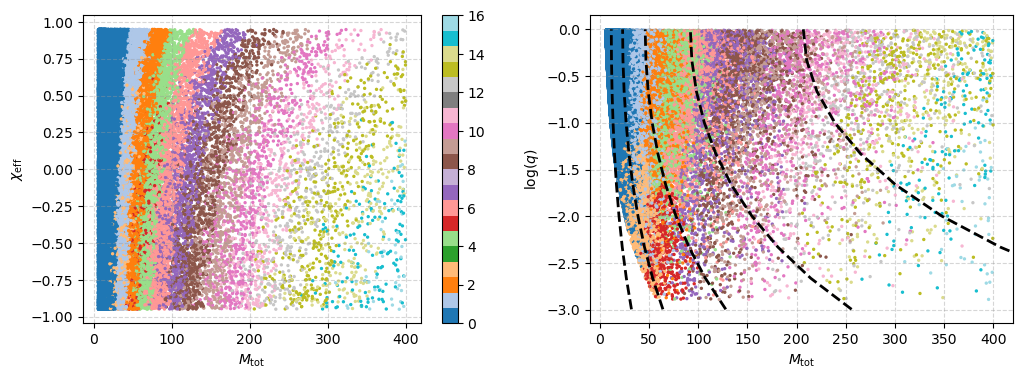

In [17]:
# Colors represent various banks, black dashed are lines of constant chirp mass, black dots are points with cos<0.96

# Plotting a subset of the samples, otherwise plot hangs
ind1=00000; ind2=100000
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(Mtotrandom[ind1:ind2],chieffrandom[ind1:ind2],c=bank_ids[ind1:ind2],s=2,cmap='tab20'); plt.colorbar()
plt.xlabel(r'$M_\mathrm{tot}$'); plt.ylabel(r'$\chi_\mathrm{eff}$')
plt.subplot(122)
plt.scatter(Mtotrandom[ind1:ind2],lnqrandom[ind1:ind2],c=bank_ids[ind1:ind2],s=2,cmap='tab20');
plt.xlabel(r'$M_\mathrm{tot}$'); plt.ylabel(r'log($q$)')

# Overplotting constant chirp mass contours for dividing banks from Roulet et al. 19
lnq=np.linspace(np.log(0.05),0,10)
q=np.exp(lnq)
eta=q/(1+q)**2
plt.plot((5/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.plot((10/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.plot((20/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.plot((40/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.plot((90/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.xlim(-10,420);

In [18]:
def gen_phases(i):
    bank_id=bank_ids[i]; p=input_pars[i]
    par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
    phases = tg.compute_hplus_hcross(f_unwrap_banks[bank_id], par_dic, 'IMRPhenomXAS', [(2, 2)])[0]
    phases = np.unwrap(np.angle(phases))
    
    phases = np.interp(f_phases_banks[bank_id],f_unwrap_banks[bank_id],phases)
    # phases = project_out(phases,basis_banks[bank_id],weights_banks[bank_id])
    return(phases)

def gram_schmidt_columns(X,measure):
    ws=measure**0.5
    Q, R = np.linalg.qr((X*ws).T)
    return Q.T/ws

def project_out(v,basis,measure):
    return v - ((v*measure) @ basis.T) @ basis

In [19]:
f_phases_banks=[]
f_unwrap_banks=[]
weights_banks=[]
basis_banks = []
for i in range(tbp.nbanks):
    f_phases_bank = np.load(os.path.join(tbp.DIR,'BBH_'+str(i),'f_phases.npy'))
    f_phases_banks.append(f_phases_bank)
    f_unwrap_banks.append(np.load(os.path.join(tbp.DIR,'BBH_'+str(i),'f_unwrap_phases.npy')))
    weights_bank = np.load(os.path.join(tbp.DIR,'BBH_'+str(i),'weights_phases.npy'))**2
    weights_banks.append(weights_bank)
    vs_bank = np.asarray([np.ones(len(f_phases_bank)),f_phases_bank])
    basis_banks.append(gram_schmidt_columns(vs_bank, weights_bank))

In [ ]:
%%time
with mp.Pool(ncores) as p:
        phases_samples = p.map(gen_phases,np.arange(len(bank_ids)))
phases_samples = np.asarray(phases_samples)

In [21]:
# Generate subbank ids

subbank_ids = np.ones(len(bank_ids),dtype=int)
for ib in range(tbp.nbanks):
    mask= (bank_ids==ib)
    mchirp_bank = Mchrandom[mask]
    subbank_id=np.zeros(len(mchirp_bank),dtype=int)
    for isb in range(tbp.nsubbanks[f'BBH_{ib}'] - 1):
        edges = json.load(open(os.path.join(tbp.DIR, f'BBH_{ib}',
                f'bank_{isb}','metadata.json'), 'r'))['Mchirp_edges']
        mask2 = (mchirp_bank>(edges[0])); mask2 *= (mchirp_bank<=(edges[1]));
        subbank_id[mask2] = isb
    # use only left edge for last bin
    isb = tbp.nsubbanks[f'BBH_{ib}'] - 1
    edges = json.load(open(os.path.join(tbp.DIR, f'BBH_{ib}',
                f'bank_{isb}','metadata.json'), 'r'))['Mchirp_edges']
    mask2 = (mchirp_bank>(edges[0]));
    subbank_id[mask2] = isb
    subbank_ids[mask] = subbank_id

In [22]:
# p_banks is the astrophysical prior probability of each (sub)bank
p_banks = []
with h5py.File(os.path.join(
    tbp.template_prior_DIR, f'calpha_samples_{nwf_init:.1e}.hdf5'), 'w') as hdf:
    for ib in range(tbp.nbanks):
        wts=weights_banks[ib]**0.5
        p_subbanks=[]
        
        for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
            mask=bank_ids==ib; mask*=subbank_ids==isb
            phases=phases_samples[mask]
            p_subbanks.append(np.sum(wt_sensitive_vol_samples[mask]))
            dire = os.path.join(tbp.DIR,f'BBH_{ib}',f'bank_{isb}')
            ndims_22 = json.load(open(os.path.join(
                dire,'metadata.json'), 'r'))['ndims']
            svd_phase_basis = np.load(os.path.join(dire,'svd_phase_basis.npy'))
            mean_phase = np.load(os.path.join(dire,'avg_phase_evolution.npy'))
            if len(phases)==0:
                raise ValueError(f'No samples in bank {ib},{isb}, is it due to nwf_init?')
            calpha_samples = tg.transform_basis(phases, mean_phase, svd_phase_basis,
                                                wts, f_phases_banks[ib])[:,:ndims_22+1]
            calpha_samples[:,ndims_22] = wt_JR_samples[mask]
            hdf.create_dataset(f'BBH_{ib}_{isb}', data=calpha_samples)
        p_banks.append(p_subbanks)
        print(f'Bank {ib}: p={np.round(np.sum(p_subbanks),4)}',np.round(p_subbanks,4))
    
# saving the input params and bank, subbank ids
np.savez(os.path.join(tbp.template_prior_DIR, f'samples_info_{nwf_init:.1e}.npz'),
        input_pars=input_pars[:,:4], bank_ids=bank_ids,
        subbank_ids=subbank_ids, p_banks=np.asarray(p_banks, dtype=object))

Bank 0: p=0.0404 [0.0055 0.0054 0.0062 0.0082 0.0152]
Bank 1: p=0.0367 [0.0041 0.0102 0.0224]
Bank 2: p=0.0448 [0.0033 0.0091 0.0324]
Bank 3: p=0.0017 [0.0004 0.0005 0.0008]
Bank 4: p=0.0598 [0.0014 0.0047 0.0537]
Bank 5: p=0.0005 [0.0001 0.0002 0.0003]
Bank 6: p=0.0884 [0.0009 0.0071 0.0803]
Bank 7: p=0.0906 [0.0009 0.0898]
Bank 8: p=0.1092 [0.0006 0.1086]
Bank 9: p=0.1208 [0.1208]
Bank 10: p=0.1176 [0.1176]
Bank 11: p=0.1145 [0.1145]
Bank 12: p=0.0837 [0.0837]
Bank 13: p=0.0563 [0.0563]
Bank 14: p=0.0261 [0.0261]
Bank 15: p=0.0081 [0.0081]
Bank 16: p=0.0006 [0.0006]


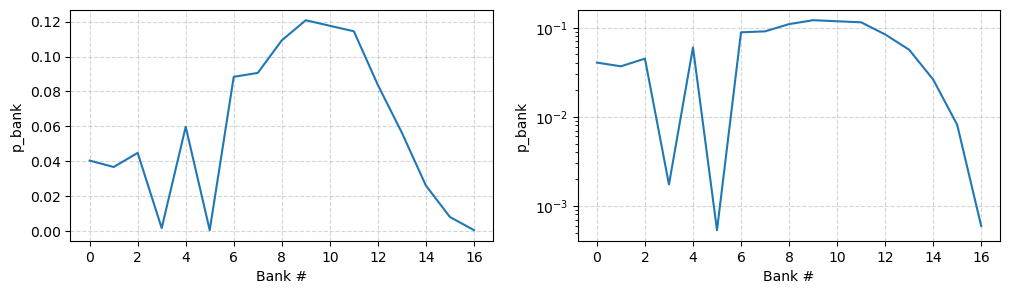

In [23]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot([np.sum(p) for p in p_banks])
plt.xlabel('Bank #'); plt.ylabel('p_bank');
plt.subplot(122)
plt.semilogy([np.sum(p) for p in p_banks])
plt.xlabel('Bank #'); plt.ylabel('p_bank');

In [ ]:
# If the samples were already generated, you could save them using the following code

# input_pars = np.load(os.path.join(tbp.template_prior_DIR,
#  f'samples_info_{nwf_init:.1e}.npz'), allow_pickle=True)['input_pars']
# Mtotrandom = input_pars[:,0] + input_pars[:,1]
# lnqrandom = np.log(input_pars[:,1]/input_pars[:,0])
# [chieffrandom , cumchidiffrandom] = inverse_transform(input_pars[:,:4].T)

# bank_ids = np.load(os.path.join(tbp.template_prior_DIR,
#  f'samples_info_{nwf_init:.1e}.npz'), allow_pickle=True)['bank_ids']
# subbank_ids = np.load(os.path.join(tbp.template_prior_DIR,
#  f'samples_info_{nwf_init:.1e}.npz'), allow_pickle=True)['subbank_ids']

### Checking the samples (optional and can ignore)

In [ ]:
calpha_samples_file = h5py.File(os.path.join(
    tbp.template_prior_DIR, f'calpha_samples_{nwf_init:.1e}.hdf5'), 'r')

In [31]:
ib=14; isb=0;
calpha_samples = calpha_samples_file[f'BBH_{ib}_{isb}'][:]

bank = tg.TemplateBank.from_json(
    os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))

In [26]:
samp_info = np.load(os.path.join(tbp.template_prior_DIR,
            f'samples_info_{nwf_init:.1e}.npz'), allow_pickle=True)
input_pars = samp_info['input_pars']; bank_ids = samp_info['bank_ids'];
subbank_ids = samp_info['subbank_ids']
Mtotrandom = input_pars[:,0] + input_pars[:,1]
lnqrandom = np.log(input_pars[:,1]/input_pars[:,0])
chieffrandom =inverse_transform(input_pars[:,:4].T)[0]

In [27]:
mask=bank_ids==ib; mask*=subbank_ids==isb

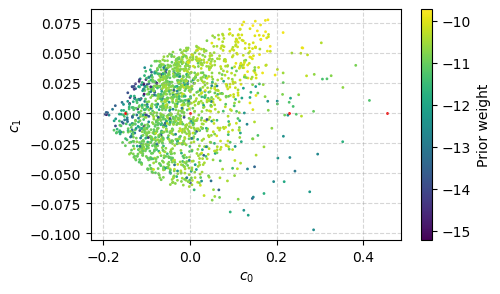

In [28]:
plt.scatter(calpha_samples[:,0], calpha_samples[:,1],c=np.log(calpha_samples[:,2]),s=1)
# plt.scatter(calpha_samples[:,0], calpha_samples[:,1],c=chieffrandom[mask],s=1)
plt.xlabel('$c_0$'); plt.ylabel('$c_1$')
plt.colorbar(label='Prior weight')
bank_grid = bank.get_coeff_grid(ndims=2, delta_calpha=tbp.delta_calpha[f'BBH_{ib}'])[:,:2]
plt.scatter(bank_grid[:,0], bank_grid[:,1],color='red',s=1)

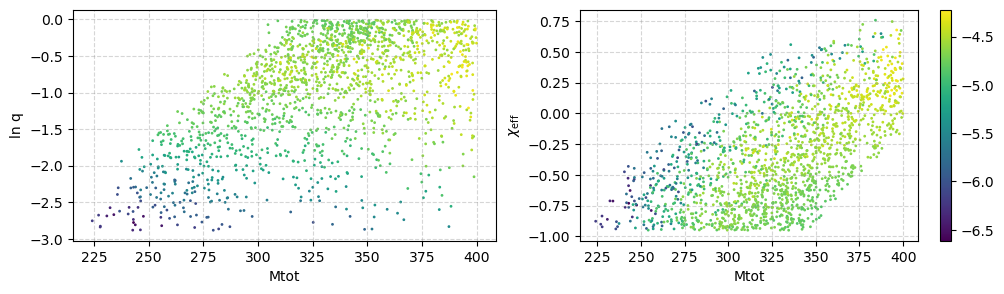

In [29]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.scatter(Mtotrandom[mask], lnqrandom[mask],c=np.log10(calpha_samples[:,2]), s=1)
plt.xlabel('Mtot'); plt.ylabel('ln q')
plt.subplot(122)
plt.scatter(Mtotrandom[mask], chieffrandom[mask],c=np.log10(calpha_samples[:,2]), s=1)
plt.xlabel('Mtot'); plt.ylabel(r'$\chi_\mathrm{eff}$')
plt.colorbar()

# 2. Model for HM amp ratio (R33, R44) samples

## 2.1 Generating HM amp ratio (R33, R44) samples

In [14]:
# For running this section, run the first few cells of section 1.1
# until you obtain amplitude bins and weights of each bin
# (until the cell before you load bank_ids)

In [13]:
samp_info = np.load(os.path.join(tbp.template_prior_DIR,
            f'samples_info_{nwf_init:.1e}.npz'), allow_pickle=True)
input_pars = samp_info['input_pars']; bank_ids = samp_info['bank_ids'];
subbank_ids = samp_info['subbank_ids']

In [14]:
def overlap(h1_dets, h2_dets,absolute=True):
    overlaps = np.sum(h1_dets * np.conj(h2_dets) * weights, axis=-1)
    if absolute: return abs(overlaps)
    else: return (overlaps)

# Taken from template bank generator
def orthogonalize_wfs(wfs, weights):
        
    full_CovMat = np.zeros((3,3),dtype = 'complex128')

    for (j,k) in np.array(np.triu_indices(3)).T:
        full_CovMat[j,k] = np.sum( weights* wfs[j]* np.conj(wfs[k]), axis=-1)

    full_CovMat[np.tril_indices(3)] = full_CovMat.T.conj()[np.tril_indices(3)]

    L = np.linalg.cholesky( np.linalg.inv(full_CovMat[::-1,::-1]) )[::-1,::-1]

    wfs = np.dot( L.conj().T, wfs)

    return(wfs, full_CovMat)

# Z are the SNR in different modes
def calculate_Z(par_dic ,orthogonalize=True):
    h1 = np.zeros((3,len(f_amp)),dtype='complex128') 
    for i in range(3): 
        h1[i] = tg.compute_hplus_hcross(f_amp, par_dic, 'IMRPhenomXHM', [(2+i, 2+i), (2+i, -2-i)])[0]/Aref;
        h1[i] /= np.sqrt(overlap(h1[i],h1[i]))
        
    if orthogonalize:
        _ , CovMat= orthogonalize_wfs(wfs=h1, weights=weights)
    else:
        _ = h1.copy()
    href = tg.compute_hplus_hcross(f_amp, par_dic, 'IMRPhenomXHM',
             [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (2, -2), (2, -1), (3, -3), (3, -2), (4, -4)])/Aref
    norm = overlap(href, href) # norm includes both h+ and hx (= SNR^2 at a fixed distance)
    href = href[0]/np.sqrt(norm[0])
    z22 = overlap(href,_[0])
    z33 = overlap(href,_[1])
    z44 = overlap(href,_[2])
    del _, h1, href
    return([z22, z33, z44, np.sum(norm)])

In [15]:
def ratios_modes(iota, p, orthogonalize=True):
    par_dic['iota'] = iota
    par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
    _ = calculate_Z(par_dic, orthogonalize=orthogonalize)
    ratio33 = _[1]/_[0]
    ratio44 = _[2]/_[0]
    # finding weights of samples corresponding to their observable volume
    # first term below is the volume factor, second is for jacobian of iota
    weights_samples = (_[3]**1.5 *1e65) * np.sin(iota)
    return [ratio33, ratio44, weights_samples]

In [16]:
ib=7; isb=0
mask=bank_ids==ib; mask*=subbank_ids==isb
pars = input_pars[mask][:25000]
mode_ratios = np.zeros((2,len(pars),3))
incl_array = np.random.rand(25000)*np.pi/2

with mp.Pool(ncores) as p:
        # Orthogonalized case (needed later for single detector trigger collection statistic)
        mode_ratios[0] = np.abs(p.starmap(ratios_modes,
                        ((incl_array[i], pars[i], True) for i in np.arange(len(pars)))))
        # Unorthogonalized case + edge-on (needed later for Javier coherent scores)
        mode_ratios[1] = np.abs(p.starmap(ratios_modes,
                        ((np.pi/2, pars[i], False) for i in np.arange(len(pars)))))
mode_ratios[0,:,2] /= np.amax(mode_ratios[0,:,2])
mode_ratios[1,:,2] /= np.amax(mode_ratios[1,:,2])

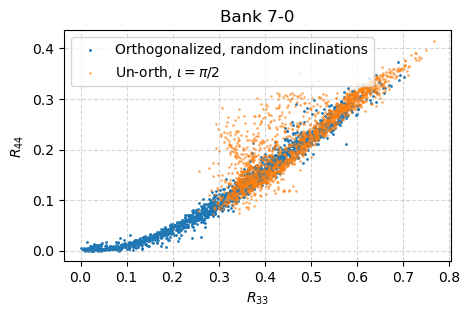

In [17]:
plt.scatter(mode_ratios[0,:,0], mode_ratios[0,:,1], s=1, 
            label=r'Orthogonalized, random inclinations')
plt.scatter(mode_ratios[1,:,0], mode_ratios[1,:,1], s=1, 
            label=r'Un-orth, $\iota=\pi/2$', alpha=0.5)
plt.legend()
plt.xlabel('$R_{33}$'); plt.ylabel('$R_{44}$');
plt.title(f'Bank {ib}-{isb}');

In [18]:
# Uncomment and use for making Rij samples for all banks
# This is a time intensive cell

hdf =  h5py.File(os.path.join(
    tbp.template_prior_DIR, f'Rij_mode_amp_ratios_{nwf_init:.1e}.hdf5'), 'w')

for ib in range(tbp.nbanks):
    print('Bank:', ib)
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        mask=bank_ids==ib; mask*=subbank_ids==isb
        pars = input_pars[mask][:25000]
        if len(pars)==0:
            raise ValueError(f'No samples in bank {ib},{isb}, is it due to nwf_init?')
        mode_ratios = np.zeros((2,len(pars),3))
        incl_array = np.random.rand(25000)*np.pi/2

        with mp.Pool(ncores) as p:
            mode_ratios[0] = np.abs(p.starmap(ratios_modes,
                                ((incl_array[i], pars[i], True) for i in np.arange(len(pars)))))
            mode_ratios[1] = np.abs(p.starmap(ratios_modes,
                                ((np.pi/2, pars[i], False) for i in np.arange(len(pars)))))
        mode_ratios[0,:,2] /= np.amax(mode_ratios[0,:,2])
        mode_ratios[1,:,2] /= np.amax(mode_ratios[1,:,2])
        hdf.create_dataset(f'BBH_{ib}_{isb}', data=mode_ratios)
hdf.close()

Bank: 0


Bank: 1
Bank: 2
Bank: 3
Bank: 4
Bank: 5
Bank: 6
Bank: 7
Bank: 8
Bank: 9
Bank: 10
Bank: 11
Bank: 12
Bank: 13
Bank: 14
Bank: 15
Bank: 16


In [20]:
# Uncomment to save a subset of these samples to the template banks
# We will use the orthogonalized samples in the triggering stage
# and if we do not train the normalizing flow (see the section below),
# we will use the unorthogonalized samples in the coherent score calculation
# in the ranking statistic later.

num_Rij_samples_saved_in_banks = 2048

hdf =  h5py.File(os.path.join(
    tbp.template_prior_DIR, f'Rij_mode_amp_ratios_{nwf_init:.1e}.hdf5'), 'r')

for ib in range(tbp.nbanks):
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        mode_ratios = hdf[f'BBH_{ib}_{isb}'][:]
        if len(mode_ratios[0])>num_Rij_samples_saved_in_banks:
            ind_random = np.random.choice(np.arange(len(mode_ratios[0])),
                size=num_Rij_samples_saved_in_banks, replace=False) # perhaps not needed
        else:
            ind_random = np.arange(len(mode_ratios[0]))
        mode_ratios = mode_ratios[:,ind_random,:]
        mode_ratios[0,:,2] /= np.sum(mode_ratios[0,:,2])
        mode_ratios[1,:,2] /= np.sum(mode_ratios[1,:,2])
        dire = os.path.join(tbp.DIR, f'BBH_{ib}/bank_{isb}/HM/')
        np.save(dire+f'HM_amp_ratio_samples.npy', mode_ratios)

In [21]:
# Keys are also saved accordingly in the template bank object for reference in the future
bank = tg.TemplateBank.from_json(tbp.DIR+f'/BBH_0/bank_0/metadata.json')
print(bank.HM_amp_ratio_samples.shape)
print()
bank.HM_amp_ratio_samples_keys

(2, 2048, 3)



{0: {'Varying_incl_orthogonalized_modes': {0: 'rho_33/rho_22',
   1: 'rho_44/rho_22',
   2: 'weights'}},
 1: {'Edge_on_incl_unorth_modes': {0: 'rho_33/rho_22',
   1: 'rho_44/rho_22',
   2: 'weights'}}}

In [ ]:
# Inclination distribution taken from Eq. (28) of Schutz et al 2011 (1102.5421)
P_incl = lambda i:  2*0.076*(1+6*np.cos(i)**2+np.cos(i)**4)**1.5 * np.sin(i)
# not used in this code, just provided for reference

## 2.2. Computing the thresholds for different glitch tests with HMs

In [ ]:
# This sub-section was originally written by Ajit Mehta and modified by Jay

# During pre-processing the data files, we make holes to remove bad data segments
# The thresholds corresponding to these holes are set by waveforms 
# with high SNR (params.DEF_PRESERVE_MAX_SNR).
# These thresholds are automatically computed in the pipeline based on 22 templates
# In this section, we include certain HM configurations for calculating the thresholds
# so that the signals with HMs are not holed

# This sub-section is optional for the pipeline,
# but increases the risk of HM signals being holed if not run

In [39]:
import triggers_single_detector_HM as trig

In [40]:
subbanks = []
for ib in range(tbp.nbanks):
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        subbanks.append([ib,isb])
subbanks = np.array(subbanks)

In [41]:
## specify the frequency band or time interval you want to compute the threshold for
sine_gaussian_intervals = params.DEF_SINE_GAUSSIAN_INTERVALS
bandlim_transient_intervals = params.DEF_BANDLIM_TRANSIENT_INTERVALS
excess_power_intervals = params.DEF_EXCESS_POWER_INTERVALS

In [ ]:
N_grid = 10 # Total number of grid points between min and max of c0 and c1 SVD coefficients
N_phi = 11 # number of samples in phi

def calc_thresholds(i):
    ib, isb = subbanks[i]
    bank = tg.TemplateBank.from_json(
        os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))
    bank.set_waveform_conditioning(2**18, 1/2048.)

    r3_max, r4_max = np.max(bank.HM_amp_ratio_samples[0][:,:2],axis=0)
    ## SNR to preserve
    preserve_max_snr = params.DEF_PRESERVE_MAX_SNR
    dt = bank.dt

    global sigma_thr_max
    sigma_thr_max = 0.
    sig_params = np.zeros(5)
    sin_gaus_thr_max = np.zeros((len(sine_gaussian_intervals)))
    sg_params = np.zeros((len(sine_gaussian_intervals), 5))
    bandlimit_thr_max = np.zeros((len(bandlim_transient_intervals)))
    bl_params = np.zeros((len(bandlim_transient_intervals), 5))
    expower_thr_max = np.zeros((len(excess_power_intervals)))
    ex_params = np.zeros((len(excess_power_intervals), 5))

    def compare_thresholds():
        global sigma_thr_max
        if sigma_thr > sigma_thr_max: 
            sigma_thr_max = sigma_thr
            sig_params[:] = [r3, r4, phic, c0, c1]
        mask = sin_gaus_thr > sin_gaus_thr_max
        sin_gaus_thr_max[mask] = sin_gaus_thr[mask]
        sg_params[mask] = [r3, r4, phic, c0, c1]
        mask = bandlimit_thr > bandlimit_thr_max
        bandlimit_thr_max[mask] = bandlimit_thr[mask]
        bl_params[mask] = [r3, r4, phic, c0, c1]
        mask = expower_thr > expower_thr_max
        expower_thr_max[mask] = expower_thr[mask]
        ex_params[mask] = [r3, r4, phic, c0, c1]

    ## looping over the meshgrid points
    for c0 in np.linspace(bank.bounds[0][0], bank.bounds[0][2], N_grid):
        for c1 in np.linspace(bank.bounds[1][0], bank.bounds[1][2], N_grid):

            wt_wvf = bank.gen_whitened_wfs_td(calpha=[c0,c1], orthogonalize=True)

            wt_wfs = wt_wvf[...,0,:]
            r3=0; r4=0; phic=0
            ## Thresholds for the tests for given bands or intervals
            YY = trig.TriggerList.get_glitch_thresholds(wt_wfs[None,:], dt, preserve_max_snr, sine_gaussian_intervals,
                                           bandlim_transient_intervals, excess_power_intervals)

            sigma_thr, sin_gaus_thr, bandlimit_thr, expower_thr = YY[0][0], np.array(YY[1][0]),\
                                                                    np.array(YY[2][0]), np.array(YY[3][0])
            compare_thresholds()
            
            r3=r3_max; r4=r4_max

            ## Azimuthal phase maximization also required when HMs are present
            for i in range(N_phi):
                phic = 2*np.pi*i/N_phi

                ## Hilbert transformations, to be used for azimuthal angle shifts in the waveform
                h22_hilbert = utils.hilbert_transform(wt_wvf[...,0,:])
                h33_hilbert = utils.hilbert_transform(wt_wvf[...,1,:])
                h44_hilbert = utils.hilbert_transform(wt_wvf[...,2,:])

                ## Waveform containing whitened 22, 33 and 44 modes
                wt_wfs = (np.cos(2*phic)*wt_wvf[...,0,:] - np.sin(2*phic)*h22_hilbert) \
                        + r3*(np.cos(3*phic)*wt_wvf[...,1,:] - np.sin(3*phic)*h33_hilbert) \
                        + r4*(np.cos(4*phic)*wt_wvf[...,2,:] - np.sin(4*phic)*h44_hilbert)

                ## Normalizing the waveform, i.e., SNR=1 
                wt_wfs /= np.linalg.norm(wt_wfs)

                ## Thresholds for the tests for given bands or intervals
                YY = trig.TriggerList.get_glitch_thresholds(wt_wfs[None,:], dt, preserve_max_snr, sine_gaussian_intervals,
                                               bandlim_transient_intervals, excess_power_intervals)

                sigma_thr, sin_gaus_thr, bandlimit_thr, expower_thr = YY[0][0], np.array(YY[1][0]),\
                                                                        np.array(YY[2][0]), np.array(YY[3][0])
                compare_thresholds()
    return(np.r_[[sig_params], sg_params, bl_params, ex_params])
    # return(sigma_thr_max, sin_gaus_thr_max, bandlimit_thr_max, expower_thr_max)

In [43]:
# Warning: This cell takes a long time to run
# Maybe check convergence of above cell w.r.t. N_grid and N_phi before running this cell

p = mp.Pool(ncores)
thresholds = p.map(calc_thresholds, np.arange(len(subbanks)))
p.close(); p.join()

In [44]:
intervals=[[],params.DEF_SINE_GAUSSIAN_INTERVALS, 
           params.DEF_BANDLIM_TRANSIENT_INTERVALS,
             params.DEF_EXCESS_POWER_INTERVALS]
intervals = [item for sublist in intervals for item in sublist]
intervals.insert(0,[])

In [45]:
# Uncomment to SAVE info in bank metadata

for i in range(len(subbanks)):
    ib, isb = subbanks[i]
    dire = os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb))
    
    with open(os.path.join(dire,'metadata.json'), 'r') as f:
        metadata = json.load(f)
        metadata['glitch_threshold_wf_params']= thresholds[i]
        metadata['glitch_threshold_intervals_saved']= intervals
    with open(os.path.join(dire,'metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=2, cls=utils.NumpyEncoder)

## 2.3. Normalizing flows to generate samples for [R33, R44, observable weights]

In [36]:
# This section generates normalizing flows (NF) for predicting R33, R44 and their
# corresponding weights given a 22 template (corresponding to a particular value of c0, c1)
# (see section "4.C.Model for amplitude ratios" in the paper for context)

# This cell is optional.
# If you do not want to add NFs to predict Rij samples,
# the pipeline will still run but will just use the saved Rij samples
# from the previous sub-section for all templates in the subbank

In [ ]:
# To use these modules in this sub-section, you need
# conda install pytorch cpuonly -c pytorch
# conda install lightning -c conda-forge
# pip install nflows

In [ ]:
# We use the samples created earlier in this notebook

calpha_samples_hdf = h5py.File(os.path.join(
    tbp.template_prior_DIR, f'calpha_samples_{nwf_init:.1e}.hdf5'), 'r')

Rij_mode_amp_ratios_hdf = h5py.File(os.path.join(
    tbp.template_prior_DIR, f'Rij_mode_amp_ratios_{nwf_init:.1e}.hdf5'), 'r')

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner

In [24]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [25]:
import ML_modules

In [26]:
# Num samples to use for training
num_samples = 25000

# Fraction of dataset used for validation vs training
val_fraction = 0.1
batch_size = 200

In [29]:
# Specify banks_dir in which NF(s) will be saved

def generate_Norm_Flow_Rij(ib, isb, max_epochs=1000, train_prog_bar=True, save_path=None):
    '''
        Generate a normalizing flow for the Rij distribution
        for a given sub-bank.
    '''
    print('----------')
    print(f'Generating for bank {ib} {isb}')
    bank = tg.TemplateBank.from_json(os.path.join(
        tbp.DIR,f'BBH_{ib}',f'bank_{isb}', "metadata.json"))
    
    # Transform the calphas to the standard normal after adding noise to mimic gridding effects
    calphas = calpha_samples_hdf[f'BBH_{ib}_{isb}'][:num_samples,:bank.ndims]
    grid_axes = bank.make_grid_axes(tbp.delta_calpha[f'BBH_{ib}']/2)
    delta_calpha_grid = np.array([np.mean(np.diff(a)) for a in grid_axes if len(a)>1])
    calphas = calphas + (np.random.rand(*calphas.shape)-0.5)*delta_calpha_grid
    calphas_mean = calphas.mean(axis=0); calphas_std = calphas.std(axis=0)
    calphas = torch.FloatTensor((calphas - calphas_mean) / calphas_std)

    Rij_raw = Rij_mode_amp_ratios_hdf[f'BBH_{ib}_{isb}'][1, :num_samples]
    Rij_mean = Rij_raw.mean(axis=0); Rij_std = Rij_raw.std(axis=0)
    Rij = torch.FloatTensor((Rij_raw - Rij_mean) / Rij_std)

    # Inititalizing the NPE
    npe = ML_modules.NeuralPosteriorEstimator(featurizer=None, d_context=bank.ndims)

    # Initialize DataLoaders for input and output
    n_samples_val = int(val_fraction * len(calphas))
    dataset_train = TensorDataset(calphas[:-n_samples_val], Rij[:-n_samples_val])
    dataset_val = TensorDataset(calphas[-n_samples_val:], Rij[-n_samples_val:])
    # dataset_train, dataset_val = random_split(dataset, [len(calphas) - n_samples_val, n_samples_val])
    train_loader = DataLoader(dataset_train, batch_size=batch_size,
                     num_workers=6, pin_memory=True, shuffle=True,
                     persistent_workers=True)
    val_loader = DataLoader(dataset_val, batch_size=batch_size,
                     num_workers=6, pin_memory=True, shuffle=False,
                     persistent_workers=True)

    # Set stopping criteria related to validation loss
    early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss",
                                        min_delta=0.00, patience=10, verbose=False, mode="min")
    
    # Store the best model based at the lowest validation loss
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=utils.DATA_ROOT,
            save_top_k=1, monitor="val_loss")

    # Train the model
    trainer = pl.Trainer(max_epochs=max_epochs, enable_progress_bar=train_prog_bar,
                        enable_checkpointing=True, logger=False, 
                        callbacks=[early_stop_callback, checkpoint_callback])
    trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

    # Reload model from lowest validation loss checkpoint
    npe = ML_modules.NeuralPosteriorEstimator.load_from_checkpoint(
        checkpoint_path=trainer.checkpoint_callback.best_model_path)
    os.remove(trainer.checkpoint_callback.best_model_path)

    # Save the transformation of calphas and Rij in the model
    npe.calphas_mean = calphas_mean; npe.calphas_std = calphas_std
    npe.Rij_mean = Rij_mean; npe.Rij_std = Rij_std

    if save_path is not None:
        torch.save(npe, save_path)
        return np.round(trainer.callback_metrics['val_loss'].item(),3)
    else:
        return npe, dataset_val

In [ ]:
# check if one particular subbank case is working
ib=7; isb=0;
npe, dataset_val = generate_Norm_Flow_Rij(ib, isb, max_epochs=100, train_prog_bar=True, save_path=None)

In [ ]:
# Uncomment and use for generating and saving NFs for all banks
# Takes a couple of hours or so to run on a CPU server
# will be much faster on a GPU

# loss = {}

# for ib in range(tbp.nbanks):
#     for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
#         loss[f'BBH_{ib}_{isb}'] = generate_Norm_Flow_Rij(ib, isb, max_epochs=500, train_prog_bar=False,
#       save_path=os.path.join(tbp.DIR, f'BBH_{ib}',f'bank_{isb}','HM',f'Rij_Norm_Flow_Coh_Score.pt'))  

In [31]:
# Checking the saved NF for a particular sub-bank as an example
# If you already have a trained npe and a dataset_val from above, 
# please skip this cell and go below for testing

ib=7; isb=0;
npe = ML_modules.NeuralPosteriorEstimator.load_from_path(
    os.path.join(tbp.DIR, f'BBH_{ib}',f'bank_{isb}','HM',f'Rij_Norm_Flow_Coh_Score.pt'))
bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,f'BBH_{ib}',f'bank_{isb}', "metadata.json"))

calphas = calpha_samples_hdf[f'BBH_{ib}_{isb}'][:num_samples,:bank.ndims] 
grid_axes = bank.make_grid_axes(tbp.delta_calpha[f'BBH_{ib}']/2)
delta_calpha_grid = np.array([np.mean(np.diff(a)) for a in grid_axes if len(a)>1])
calphas = calphas + (np.random.rand(*calphas.shape)-0.5)*delta_calpha_grid
calphas_mean = calphas.mean(axis=0); calphas_std = calphas.std(axis=0)

# The index 1 below corresponds to the Javier coherent score case
# If you use index 0, it corresponds to single detector trigger collection statistic case
Rij_raw = Rij_mode_amp_ratios_hdf[f'BBH_{ib}_{isb}'][1, :num_samples]
Rij_mean = Rij_raw.mean(axis=0); Rij_std = Rij_raw.std(axis=0)

calphas = torch.FloatTensor((calphas - npe.calphas_mean) / npe.calphas_std)
Rij = torch.FloatTensor((Rij_raw - npe.Rij_mean) / npe.Rij_std)

val_fraction = 0.1
n_samples_val = int(val_fraction * len(calphas))
dataset_val = TensorDataset(calphas[-n_samples_val:], Rij[-n_samples_val:])

In [32]:
test_ind = 20
context = npe.featurizer(dataset_val[test_ind][0]).unsqueeze(0)

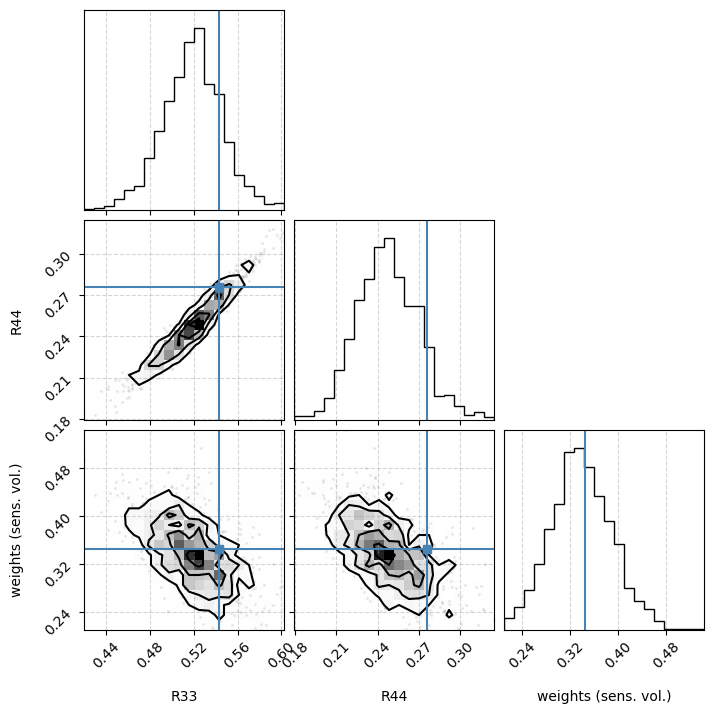

In [33]:
# plt.figure(figsize=(12,8))
samples_test = npe.flow.sample(num_samples=1000, context=context) 
samples_test = samples_test.detach().numpy()* npe.Rij_std + npe.Rij_mean
mask = np.any(samples_test<0, axis=-1)
samples_test = samples_test[~mask]
corner.corner(samples_test, labels=["R33", "R44",'weights (sens. vol.)'],
               truths=dataset_val[test_ind][1]* npe.Rij_std + npe.Rij_mean);

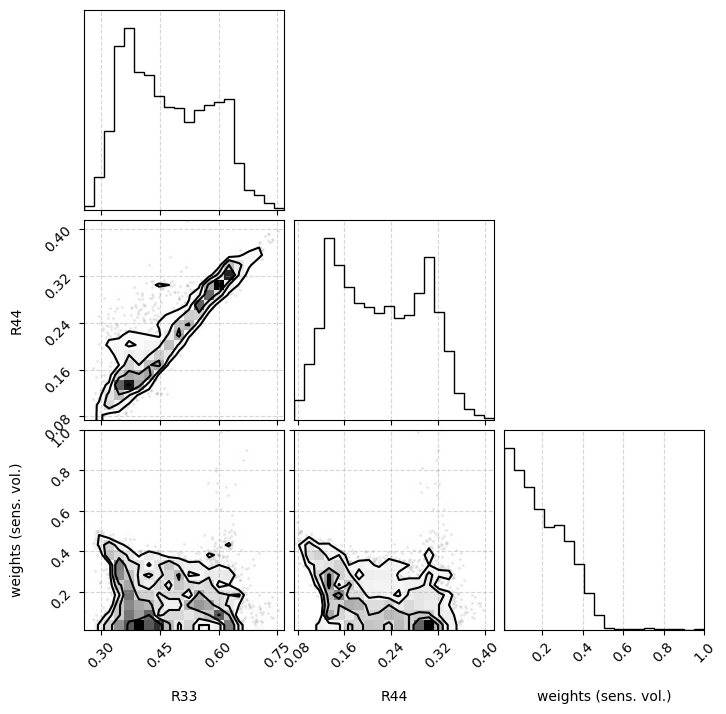

In [34]:
# Samples for the whole subbank, just for comparison

Rij_raw = Rij_mode_amp_ratios_hdf[f'BBH_{ib}_{isb}'][1, :num_samples]
corner.corner(Rij_raw, labels=["R33", "R44",'weights (sens. vol.)']);

# 3. Making template prior object (using normalizing flows)

In [ ]:
# Our templates correspond to a particular value of SVD coefficients
# Some templates account for a lot more astrophysical prior samples than others
# Therefore, in this section, we calculate the astrophysical prior weight for each template

# This cell is optional for the pipeline
# If not run, equal prior will be assigned for all templates in the banks

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner
import ML_modules

In [7]:
# We again use the samples created earlier in this notebook
# according to the astrophysical distribution
# as specified in the paper

num_samples_use = 25000
# Fraction of dataset used for validation vs training
val_fraction = 0.1
batch_size = 100
hidden_size = 32
nlayers = 4

In [ ]:
# I will use these cumulative prior values obtained from the astrophysical distribution
# to normalize the template prior
cum_prior_banks = []
for ib in range(tbp.nbanks):
    cum_prior_bank=[]
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        cum_prior_bank.append(np.sum(calpha_samples_hdf[f'BBH_{ib}_{isb}'][:,2]))
    cum_prior_banks.append(cum_prior_bank)

In [39]:
def generate_Template_Prior_NF(ib, isb, train_prog_bar=True, save_path=None):
    '''
    :param ib: Bank number
    :param isb: Sub-bank number
    :param train_prog_bar: Whether to show progress bar during training
    :param save_path: Path to save the trained model. If none, the model is returned
                    for debugging and testing purposes
    '''
    print('----------')
    print(f'Generating for bank {ib} {isb}')
    bank = tg.TemplateBank.from_json(
        os.path.join(tbp.DIR,f'BBH_{ib}',f'bank_{isb}', "metadata.json"))
    calphas_raw = calpha_samples_hdf[f'BBH_{ib}_{isb}'][:num_samples_use,:bank.ndims]
    weights_raw =Rij_mode_amp_ratios_hdf[f'BBH_{ib}_{isb}'][1][:num_samples_use,-1] 
    
    # Transform the calphas to the standard normal after adding noise to mimic gridding effects
        # Gaussian noise is another alternative but we use uniform noise here
        # calphas = calphas_raw + np.random.randn(*calphas_raw.shape)*tbp.delta_calpha[f'BBH_{ib}']/8
    grid_axes = bank.make_grid_axes(tbp.delta_calpha[f'BBH_{ib}']/2)
    delta_calpha_grid = np.array([np.mean(np.diff(a)) for a in grid_axes if len(a)>1])
    calphas_noisy = calphas_raw + (np.random.rand(*calphas_raw.shape)-0.5)*delta_calpha_grid
    calphas_mean = calphas_noisy.mean(axis=0); calphas_std = calphas_noisy.std(axis=0)
    calphas_noisy = (calphas_noisy - calphas_mean) / calphas_std
    calphas_noisy  = torch.FloatTensor(calphas_noisy)

    # Create the dataloaders for training and validation
    n_samples_val = int(val_fraction * len(calphas_noisy))
    dataset = TensorDataset(calphas_noisy, torch.FloatTensor(weights_raw))
    dataset_train, dataset_val = torch.utils.data.random_split(
                            dataset, [len(calphas_noisy) - n_samples_val, n_samples_val])
    train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=5,
                               pin_memory=True, shuffle=True, persistent_workers=True)
    val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=5,
                             pin_memory=True, shuffle=False, persistent_workers=True)

    # Create the model
    npe = ML_modules.Template_Prior_NF(d_in=bank.ndims, d_hidden_flow=hidden_size,
                                        n_layers_flow=nlayers)
                         
    # Set early stopping criteria related to validation loss
    early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss",
                                     min_delta=0.00, patience=10, verbose=False, mode="min")
    
    # Store the best model based at the lowest validation loss
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=utils.DATA_ROOT,
            save_top_k=1, monitor="val_loss")

    # Train the model
    trainer = pl.Trainer(max_epochs=1000, enable_progress_bar=train_prog_bar,
                        enable_checkpointing=True, logger=False, 
                        callbacks=[early_stop_callback, checkpoint_callback])
    trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

    # Reload model from lowest validation loss
    npe = ML_modules.Template_Prior_NF.load_from_checkpoint(
        checkpoint_path=trainer.checkpoint_callback.best_model_path)
    os.remove(trainer.checkpoint_callback.best_model_path)
    
    # Summing over templates and normalizing the prior to the value
    # from the astrophysical distribution
    coeff_grid = bank.get_coeff_grid(
        delta_calpha=tbp.delta_calpha[f'BBH_{ib}']/2,force_zero=True,
        remove_nonphysical=False)[...,:bank.ndims]
    coeff_grid_norm = (coeff_grid - calphas_mean) / calphas_std
    prior = -npe.loss(torch.FloatTensor(coeff_grid_norm)).detach().numpy()
    npe.log_bank_norm =  np.log(cum_prior_banks[ib][isb]\
                        /np.sum(np.exp(prior) * np.prod(delta_calpha_grid)))
    
    # Finding the value to reject templates based if their prior is below a certain threshold
    npe.calpha_reject_threshold = np.quantile(npe.loss(calphas_noisy).detach().numpy(),1-3e-3)
    npe.calpha_reject_threshold = npe.log_bank_norm - npe.calpha_reject_threshold
    npe.calphas_mean = calphas_mean; npe.calphas_std = calphas_std
    if save_path is not None:
        torch.save(npe, save_path)
        return np.round(trainer.callback_metrics['val_loss'].item(),3)
    else:
        return npe

In [ ]:
ib=7; isb=0;
npe = generate_Template_Prior_NF(ib, isb, train_prog_bar=True, save_path=None)

In [ ]:
# Generating for all the banks (uncomment to run)

# for ib in range(17):
#     for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
#         generate_Template_Prior_NF(ib, isb, train_prog_bar=False,
#           save_path=os.path.join(tbp.DIR, f'BBH_{ib}',f'bank_{isb}','Template_Prior_Norm_Flow.pt'))

In [41]:
# Checking the saved NF for a particular sub-bank as an example
# If you already have a trained npe and a dataset_val, please skip this cell

ib=7; isb=0;

npe = ML_modules.Template_Prior_NF.load_from_path(
    os.path.join(tbp.DIR, f'BBH_{ib}',f'bank_{isb}','Template_Prior_Norm_Flow.pt'))

In [ ]:
bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,f'BBH_{ib}',f'bank_{isb}', "metadata.json"))
grid_axes = bank.make_grid_axes(tbp.delta_calpha[f'BBH_{ib}']/2)
delta_calpha_grid = np.array([np.mean(np.diff(a)) for a in grid_axes if len(a)>1])

calphas_raw = calpha_samples_hdf[f'BBH_{ib}_{isb}'][:num_samples_use,:bank.ndims]
# Adding noise and then normalizing the calphas
calphas_noisy = calphas_raw + (np.random.rand(*calphas_raw.shape)-0.5)*delta_calpha_grid

weights_raw = Rij_mode_amp_ratios_hdf[f'BBH_{ib}_{isb}'][1][:num_samples_use,-1] 

Text(0.5, 1.0, 'Samples generated from the flow')

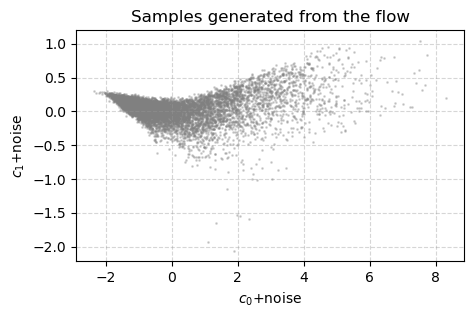

In [45]:
samples_test = npe.flow.sample(num_samples=10000).detach().numpy()
samples_test = (samples_test * npe.calphas_std) + npe.calphas_mean
plt.scatter(samples_test[:,0], samples_test[:,1], alpha=0.3, color='gray', s=1)
plt.xlabel('$c_0$+noise'); plt.ylabel('$c_1$+noise')
plt.title('Samples generated from the flow')

# Under the hood, it is executing simple transforms sequentially
# You can look at transforms from individual layers by changing np.arange(...) below
# z = torch.FloatTensor(np.random.randn(10000,2))
# for i in np.arange(7,-1,-1):
#     z = npe.flow._transform._transforms[i].inverse(z)[0]

In [11]:
coeff_grid = bank.get_coeff_grid(delta_calpha=tbp.delta_calpha[f'BBH_{ib}']/2, force_zero=True,
                                 remove_nonphysical=False)[...,:2]

Text(0.5, 1.0, 'Log$_{10}$ sensitive distance')

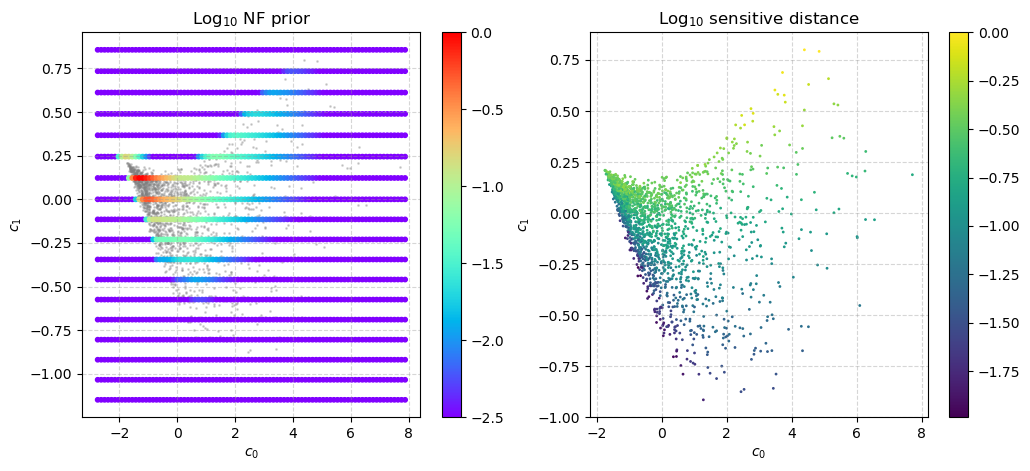

In [47]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(calphas_raw[:,0], calphas_raw[:,1], s=1, alpha=0.3, color='gray')
plt.xlabel('$c_0$'); plt.ylabel('$c_1$')
color = npe.log_prior(coeff_grid)/np.log(10)
plt.scatter(coeff_grid[:,0], coeff_grid[:,1], c=color-np.amax(color),
        s=10, vmin=-2.5, cmap='rainbow', alpha=1)
plt.colorbar()
plt.title('Log$_{10}$ NF prior')

plt.subplot(122)
plt.scatter(calphas_raw[:,0], calphas_raw[:,1], c = np.log10(weights_raw), s=1)
plt.xlabel('$c_0$'); plt.ylabel('$c_1$')
plt.colorbar()
plt.title('Log$_{10}$ sensitive distance')

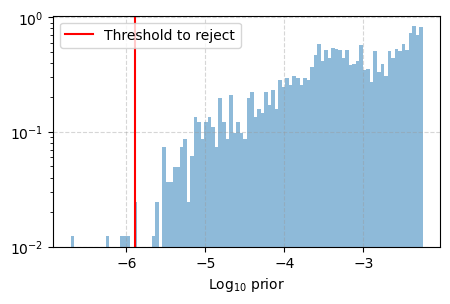

In [48]:
plt.hist(npe.log_prior(calphas_noisy)/np.log(10),
        density=True, bins=100, alpha=0.5, log=True);
plt.axvline(npe.calpha_reject_threshold/np.log(10), color='r', label="Threshold to reject")
plt.xlabel('Log$_{10}$ prior'); plt.legend();

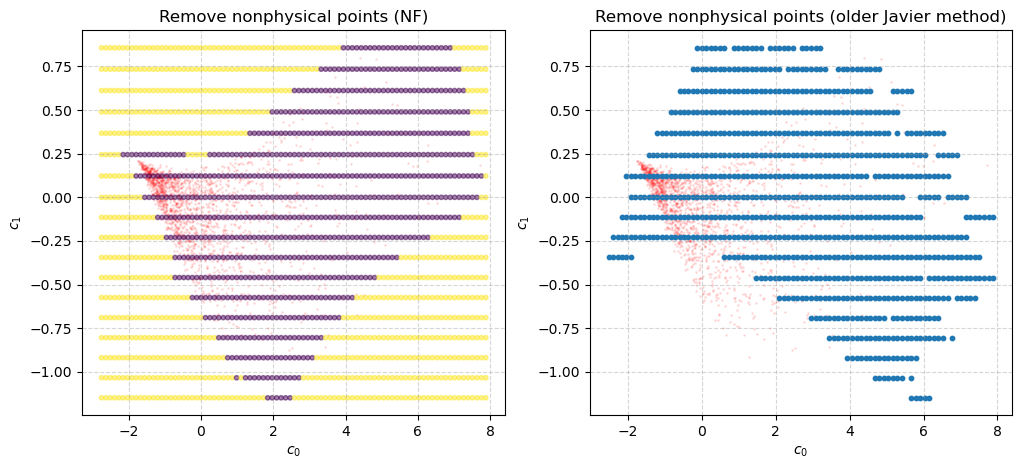

In [49]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(calphas_raw[:,0], calphas_raw[:,1], s=1, alpha=0.1, color='red')
plt.xlabel('$c_0$'); plt.ylabel('$c_1$')
plt.scatter(coeff_grid[:,0], coeff_grid[:,1],
    c=npe.log_prior(coeff_grid)<npe.calpha_reject_threshold, s=10, alpha=0.5)
# plt.colorbar()
plt.title(f'Remove nonphysical points (NF)')

plt.subplot(122)
plt.scatter(calphas_raw[:,0], calphas_raw[:,1], s=1, alpha=0.1, color='red')
plt.xlabel('$c_0$'); plt.ylabel('$c_1$')
saved_NF = bank.Template_Prior_NF
# Removing the template prior automatically activates older
# Javier's method of removing non-physical points
bank.Template_Prior_NF = None
coeff_grid_JR = bank.get_coeff_grid(delta_calpha=tbp.delta_calpha[f'BBH_{ib}']/2,
                                 remove_nonphysical=True)[...,:2]
bank.Template_Prior_NF = saved_NF
plt.scatter(coeff_grid_JR[:,0], coeff_grid_JR[:,1], s=10)
plt.title(f'Remove nonphysical points (older Javier method)');

# The older Javier method removes non-physical points based on the samples used for 
# constructing template banks in notebook #1, whereas we use a different set of samples here,
# which can lead to some differences. One thing to note is the NF method does not produce
# spurious holes

In [50]:
# check if the norm by summing over the grid is the same as the normalization constant

print(np.sum(np.exp(npe.log_prior(coeff_grid))\
     * np.prod(delta_calpha_grid)), cum_prior_banks[ib][isb])

0.0015992755 0.0015992754952946831


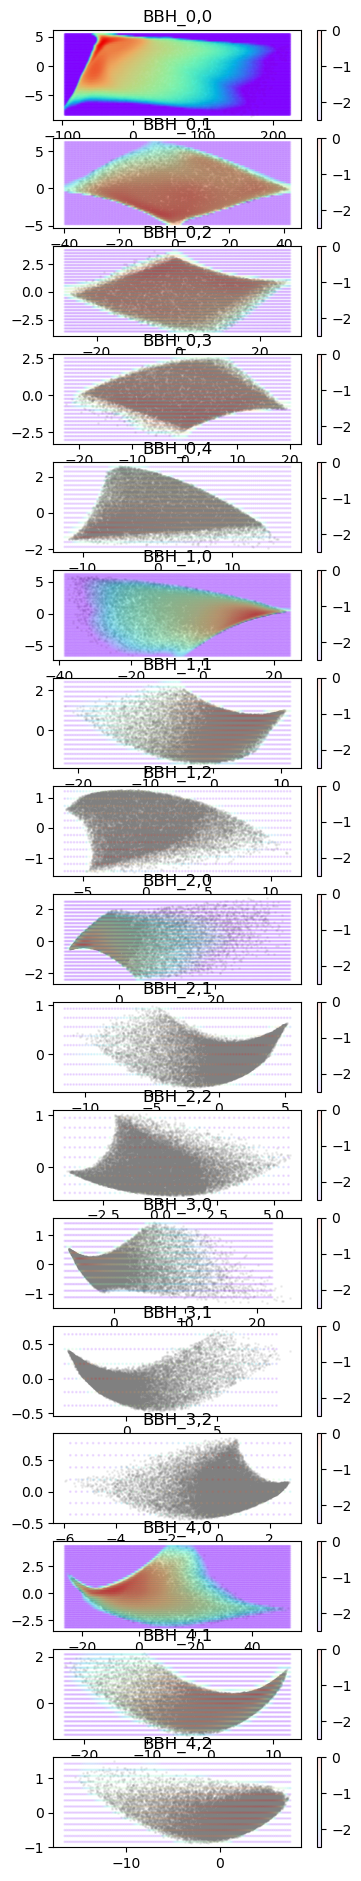

In [ ]:
# Extra comparison (can skip)
# Making a plot for many banks at ones for visual inspection

sum_ind=1
for ib in range(0,5):
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        sum_ind+=1

ind=1
plt.figure(figsize=(4,25))
for ib in range(0,5):
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        plt.subplot(sum_ind,1,ind); ind+=1
        plt.title(f'BBH_{ib},{isb}')
        bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,f'BBH_{ib}',f'bank_{isb}', "metadata.json"))
        npe = ML_modules.Template_Prior_NF.load_from_path(
            os.path.join(tbp.DIR, f'BBH_{ib}',f'bank_{isb}','Template_Prior_Norm_Flow.pt'))
        calphas_raw = np.load(samples_dir+f'/BBH_{ib}_{isb}_calpha_samples.npy')[:num_samples_use,:bank.ndims]
        coeff_grid = bank.get_coeff_grid(delta_calpha=tbp.delta_calpha[f'BBH_{ib}']/2, force_zero=True,
                                        remove_nonphysical=False)[...,:2]
        plt.scatter(calphas_raw[:,0], calphas_raw[:,1], s=1, alpha=0.1, color='gray')
        color = npe.log_prior(coeff_grid)/np.log(10)
        plt.scatter(coeff_grid[:,0], coeff_grid[:,1], c=color-np.amax(color),
                s=1, vmin=-2.5, cmap='rainbow', alpha=0.1)
        plt.colorbar()

# Extras

In [ ]:
# Please ignore this section

In [ ]:
    # calphas = calphas_raw + np.random.randn(*calphas_raw.shape)*tbp.delta_calpha[f'BBH_{ib}']/8

In [ ]:
# Function for changing settings while making plots for paper
# useful as usetex settings are sometimes expensive
import matplotlib as mpl
def mpl_settings(settings):
    if (settings=='default'):
        mpl.rc('text', usetex=False)
        mpl.rcParams['legend.fontsize'] = 'medium'
        plt.rcParams["xtick.labelsize"] = 'medium'
        plt.rcParams["ytick.labelsize"] = 'medium'
        plt.rcParams['axes.labelsize'] = 'medium' 
        plt.rcParams["figure.figsize"] = [5.0, 3.0]
    elif(settings=='paper'):
        mpl.rc('text', usetex=True)
        plt.rcParams["xtick.labelsize"] = 13; plt.rcParams["ytick.labelsize"] = 13
        plt.rcParams['axes.labelsize']=16
        
mpl_settings('paper')

In [ ]:
weights_banks = pickle.load(open(
    '/data/jayw/IAS/GW/Data/HM_O3a_search/Template_prior_HM_banks_Mtot-2_prior.pickle','rb'))['weights_banks']
weights_banks_2 = np.array([np.sum(weights_banks[ib]) for ib in range(17)])
weights_banks = pickle.load(open(
    '/data/jayw/IAS/GW/Data/HM_O3a_search/Template_prior_HM_banks_Mtot-3_prior.pickle','rb'))['weights_banks']
weights_banks_3 = np.array([np.sum(weights_banks[ib]) for ib in range(17)])

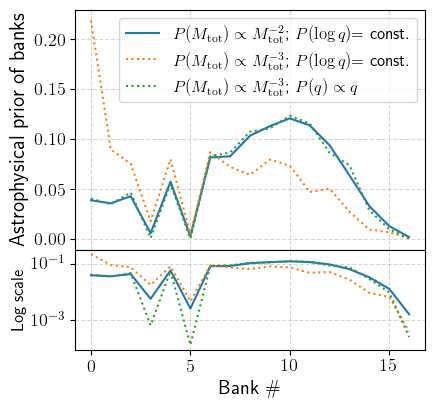

In [ ]:
fig = plt.figure(num=None, figsize=(10, 4))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

ax1 = fig.add_axes([0.05, 0.4, 0.35, 0.6]);
ax2 = fig.add_axes([0.05, 0.15, 0.35, 0.25]);
ax1.plot(weights_banks_2, label=r'$P(M_\mathrm{tot})\propto M_\mathrm{tot}^{-2}$; $P(\mathrm{log}\, q)$= const.')
ax1.plot(weights_banks_3, label=r'$P(M_\mathrm{tot})\propto M_\mathrm{tot}^{-3}$; $P(\mathrm{log}\, q)$= const.', ls='dotted')
ax1.plot([np.sum(p) for p in p_banks], ls='dotted', label=r'$P(M_\mathrm{tot})\propto M_\mathrm{tot}^{-3}$; $P(q)\propto q$')
ax1.set_ylabel('Astrophysical prior of banks', fontsize=15);
ax1.legend(fontsize=12)
ax2.semilogy(weights_banks_2)
ax2.semilogy(weights_banks_3, ls='dotted')
ax2.semilogy([np.sum(p) for p in p_banks], ls='dotted')
ax2.set_xlabel(r'Bank $\#$', fontsize=14); ax2.set_ylabel('Log scale', fontsize=12);
# plt.savefig('/data/jayw/CCA/Plots/trash.pdf', bbox_inches='tight')

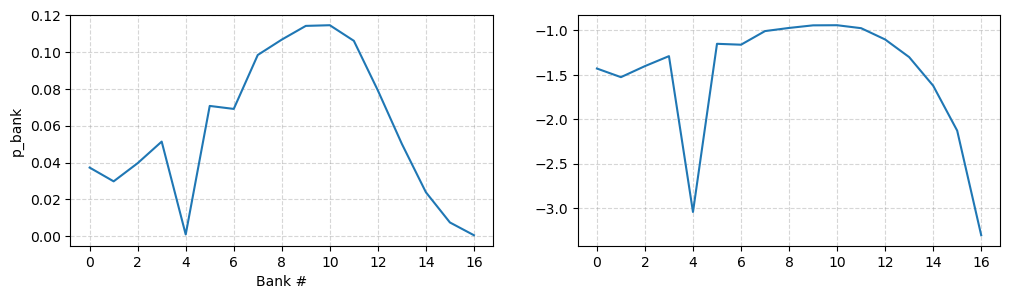

In [ ]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot([np.sum(p) for p in p_banks])
plt.xlabel('Bank #'); plt.ylabel('p_bank');
plt.subplot(122)
plt.semilogy([np.sum(p) for p in p_banks])

## Making template prior object using Jonathan's method

In [ ]:
# This method was superseded by Normalizing flows above
# It is kept here just for reference
# see Olsen et al 2022 for details regarding this prior

In [ ]:
data_dir = '/data/jayw/IAS/GW/Data/HM/Template_prior/calpha_samples_1e7'

In [ ]:
# Once BBH_{ib}_{isb}_calpha_samples.npy files are generated,
# the following function makes the template prior pickle file

# First run with the default: force_smoothing_kernel=False
# one could in-principle later change it to True if you want to make the template prior sharper 
# (especially for the high banks). If set True, you would need to manually populate the
# forced_sigma_noise dictionary in template_bank_generator_HM.py

# tg.summarize_prior(data_dir, data_dir, name='Template_prior_HM_banks', force_smoothing_kernel=False)

In [ ]:
import pickle
PD = pickle.load( open(data_dir+'/Template_prior_HM_banks.pickle','rb'))

In [ ]:
# Add the p_banks weights calculated above to the template prior file
# need to only do once

# samp_info = np.load(data_dir + '/samples_info.npz', allow_pickle=True)
# PD['weights_banks'] = list(samp_info['p_banks'])
# pickle.dump(file=open(data_dir+'/Template_prior_HM_banks.pickle', mode='wb'), obj=PD)

In [ ]:
ib=2; isb=0

bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))
bank_grid = bank.get_coeff_grid(ndims=2, delta_calpha=tbp.delta_calpha[f'BBH_{ib}']);

In [ ]:
calpha_samples = np.load(data_dir+f'/BBH_{ib}_{isb}_calpha_samples.npy')

In [ ]:
p = PD['prior'][f'BBH_{ib}'][isb];
#p /= np.sum(p)
edges = PD['hist_axes_edges'][f'BBH_{ib}'][isb]

In [ ]:
interp_func, ndim = tg.get_prior_interp_func(f'BBH_{ib}', isb, 2,
        prior_data_file_path = data_dir+'/Template_prior_HM_banks.pickle')
ndim

2

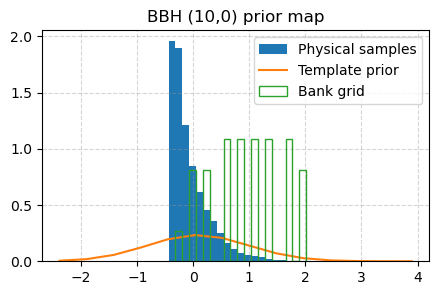

In [ ]:
# For a particular bank where ndim=1 (the prior being wide is okay as it compensates for calpha being shifted due to noise)
_,bins,_ = plt.hist(calpha_samples[:,0],density=True, bins=20, label='Physical samples');
plt.plot((edges[0][1:]+edges[0][:-1])/2, p*10, label='Template prior');
plt.hist(bank_grid[:,0], histtype='step',density=True, bins=bins, label='Bank grid')
plt.title(f'BBH ({ib},{isb}) prior map'); plt.legend();

Text(0.5, 1.0, 'BBH (10,0)  $\\log p$')

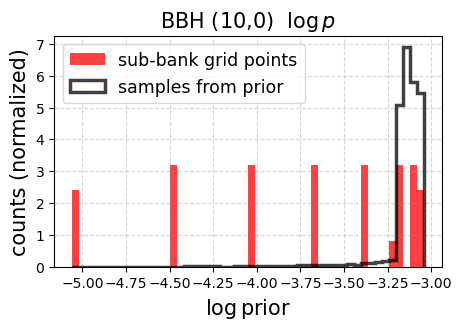

In [ ]:
_,bins,_ = plt.hist(np.log(interp_func(bank_grid[:,:ndim])), bins=50, alpha=0.75,
         label='sub-bank grid points', density=True, histtype='stepfilled', color='r');
plt.hist(np.log(interp_func(calpha_samples[:,:ndim])), bins=bins, alpha=0.75,
         label='samples from prior', density=True, histtype='step',color='k', linewidth=2.5);

plt.legend(fontsize=12.5, loc='upper left')
plt.ylabel('counts (normalized)', fontsize=15)
plt.xlabel(r'$\log {\rm prior}$', fontsize=15)
# axs[1,1].yaxis.set_label_position("right")
# axs[1,1].yaxis.tick_right()
plt.title(f'BBH ({ib},{isb})  $\log p$', fontsize=15)
# plt.xlim(left=-10);

Text(0.5, 1.0, 'BBH (2,0) prior map')

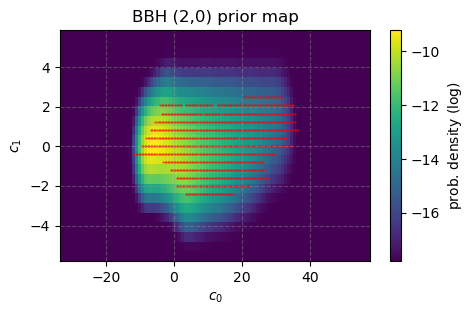

In [ ]:
# For a banks where ndim=2
extent=[edges[0][0],edges[0][-1], edges[1][0],edges[1][-1]]
im10 = plt.imshow(np.log(p).T, interpolation='None',
                extent=extent, origin='lower', aspect='auto');
plt.xlabel(r'$c_0$');
plt.ylabel(r'$c_1$');
bank_grid = bank.get_coeff_grid(ndims=2, delta_calpha=tbp.delta_calpha[f'BBH_{ib}'])[:,:2]
plt.scatter(bank_grid[:,0],bank_grid[:,1],marker='.',color='r', s=0.5)
# plt.scatter(calpha_samples[:,0], calpha_samples[:,1],c='r', s=0.2, alpha=0.2)
cbar10 = plt.colorbar(im10)
cbar10.set_label(r'prob. density $(\log)$', rotation=90)

plt.title(f'BBH ({ib},{isb}) prior map')

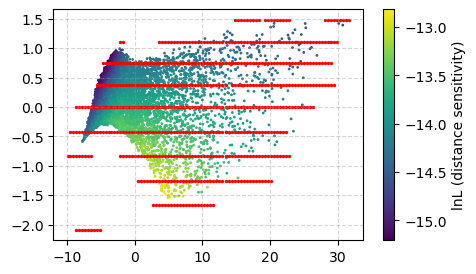

In [ ]:
plt.scatter(calpha_samples[:,0], calpha_samples[:,1],c=np.log(calpha_samples[:,2]),s=1)
cbar = plt.colorbar(); cbar.set_label('lnL (distance sensitivity)')
plt.scatter(bank_grid[:,0], bank_grid[:,1], s=2, color='red');

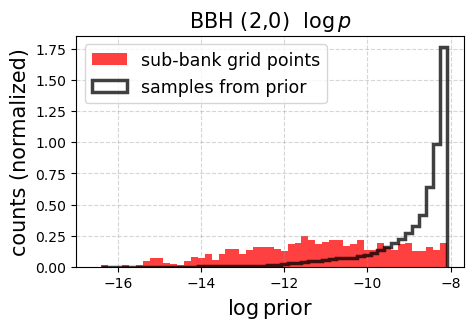

In [ ]:
_,bins,_ = plt.hist(np.log(interp_func(bank_grid[:,:ndim])), bins=50, alpha=0.75,
         label='sub-bank grid points', density=True, histtype='stepfilled', color='r');
plt.hist(np.log(interp_func(calpha_samples[:,:ndim])), bins=bins, alpha=0.75,
         label='samples from prior', density=True, histtype='step',color='k', linewidth=2.5);

plt.legend(fontsize=12.5, loc='upper left')
plt.ylabel('counts (normalized)', fontsize=15)
plt.xlabel(r'$\log {\rm prior}$', fontsize=15)
# axs[1,1].yaxis.set_label_position("right")
# axs[1,1].yaxis.tick_right()
plt.title(f'BBH ({ib},{isb})  $\log p$', fontsize=15)
plt.xlim(left=-17);

Text(0.5, 1.0, 'Template prior (Jonathan)')

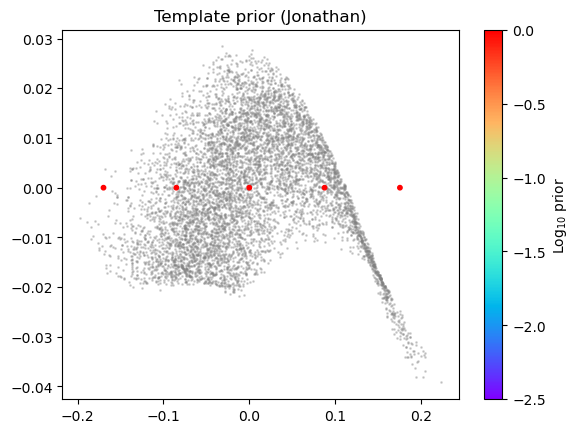

In [ ]:
# Extra comparison (can skip)
# If you haven't made the JM prior, please ignore this cell
JM_template_prior = f'/data/jayw/IAS/GW/Data/HM_O3b_search/Template_prior_HM_banks.pickle'
plt.scatter(calphas_raw[:,0], calphas_raw[:,1], s=1, alpha=0.3, color='gray')
coeff_grid = bank.get_coeff_grid(delta_calpha=tbp.delta_calpha[f'BBH_{ib}']/2, force_zero=True,
                                 remove_nonphysical=False)[...,:2]
color, ndim = tg.get_prior_interp_func(f'BBH_{ib}',isb, ndim=2, prior_data_file_path=JM_template_prior)
color = color(coeff_grid[:,:ndim])
color=np.log10(color/np.max(color))
plt.scatter(coeff_grid[:,0], coeff_grid[:,1], c=color, s=10, vmin=-2.5, cmap='rainbow')
plt.colorbar(label='Log$_{10}$ prior')
plt.title(f'Template prior (Jonathan)')

In [ ]:
converge = np.log(interp_func(bank_grid[:,:ndim]))

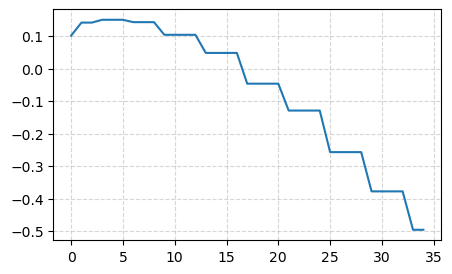

In [ ]:
plt.plot(converge - np.log(interp_func(bank_grid[:,:ndim])))

In [ ]:
# Checking whether the we roughly recover the individual weights of the banks

In [ ]:
p_banks=[]
for ib in range(17):
    p_subbanks=[]
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        interp_func, ndim = tg.get_prior_interp_func(f'BBH_{ib}', isb, 2,
                prior_data_file_path=data_dir+'/Template_prior_HM_banks.pickle')
        bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))
        bank_grid = bank.get_coeff_grid(ndims=2, delta_calpha=0.7)
        p_subbanks.append(np.sum(interp_func(bank_grid[:,:ndim])))
    p_banks.append(p_subbanks)

In [ ]:
weights_banks = pickle.load(open(
    '/data/jayw/IAS/GW/Data/HM_O3a_search/Template_prior_HM_banks.pickle','rb'))['weights_banks']
weights_banks = np.array([np.sum(weights_banks[ib]) for ib in range(17)])

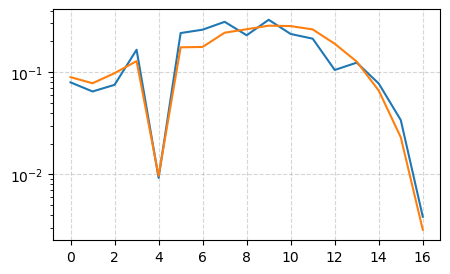

In [ ]:
plt.plot([np.sum(p) for p in p_banks])
plt.plot( weights_banks*2.5)
plt.yscale('log')

In [ ]:
# delete below

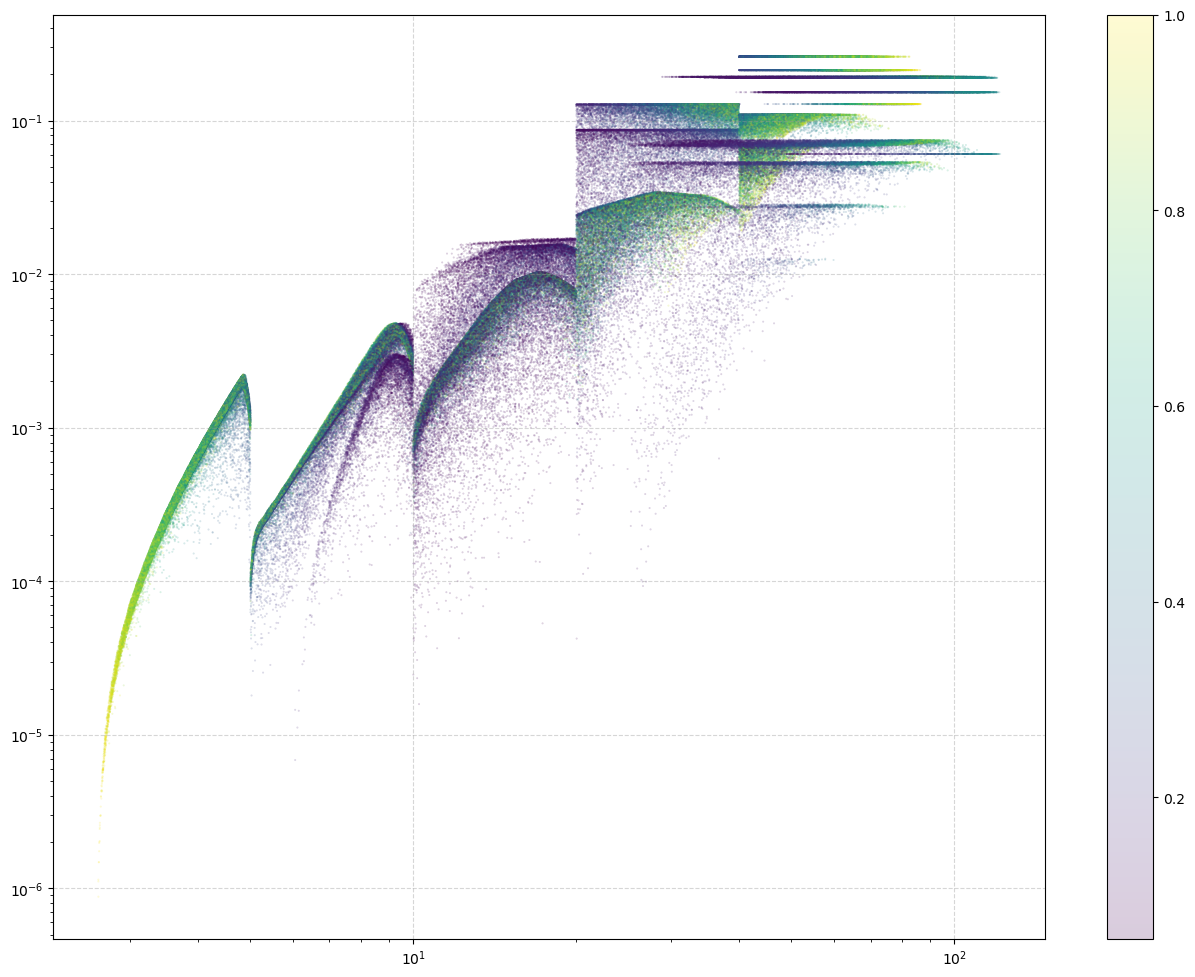

In [ ]:
plt.figure(figsize=(16,12));
PD = pickle.load( open('/scratch/lustre/tejaswi/GW'+'/PriorData_light.pkl','rb'))
# ib=3
# markers=["o", "x", "^", "+"]
for ib in range(6):
    multibank = tg22.MultiBank.from_json(os.path.join(tbp22.DIR,'BBH_'+str(ib)+'_multibank','metadata.json'))
    for isb, bank in enumerate(multibank.subbanks):
        # bank_grid = bank.get_coeff_grid(delta_calpha=tbp22.delta_calpha[f'BBH_{ib}'], fudge=tbp22.fudge[f'BBH_{ib}']);
        p = PD['prior'][f'BBH_{ib}'][isb];
        interp_func, ndim = tg22.get_prior_interp_func(f'BBH_{ib}', isb, 5,
            prior_data_file_path = '/scratch/lustre/tejaswi/GW/PriorData_light.pkl')
        plt.scatter(bank.transform_pars(bank.pars)[:,0], interp_func(bank.coeffs[:,:ndim]), 
                    s=0.2, c=bank.pars[:,1]/bank.pars[:,0], vmin=1/18, vmax=1, alpha=0.2)
                    # marker=markers[isb], alpha=0.2, label=f"({ib}, {isb})")
    # plt.scatter(bank.transform_pars(bank.pars)[:,0], interp_func(bank.coeffs[:,:ndim]), 
    #             s=0.2, c=bank.transform_pars(bank.pars)[:,2], vmin=-1, vmax=1)
        if isb==0 and ib==0:
            plt.colorbar()
plt.yscale('log')
plt.xscale('log')
# plt.legend()

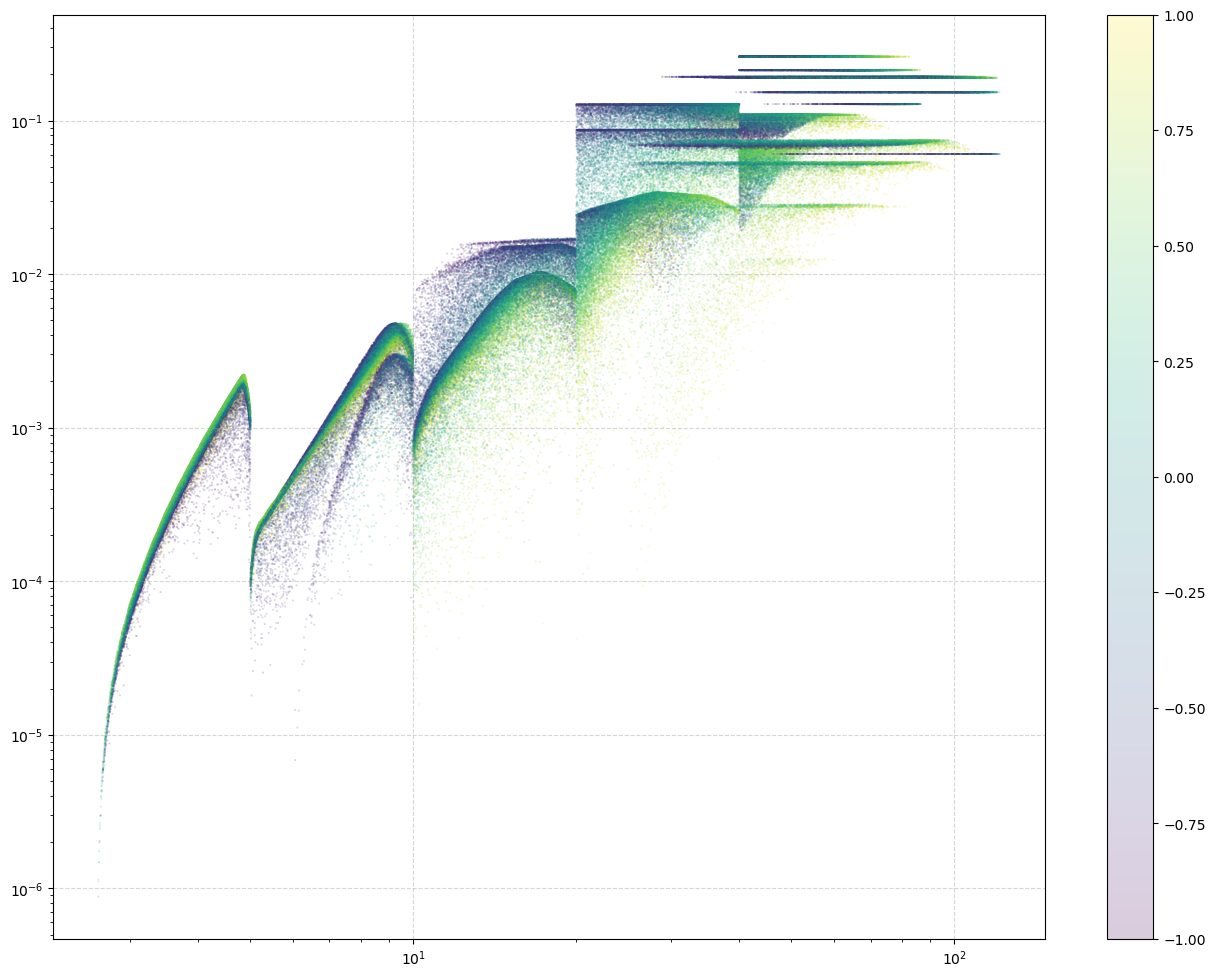

In [ ]:
plt.figure(figsize=(16,12));
PD = pickle.load( open('/scratch/lustre/tejaswi/GW'+'/PriorData_light.pkl','rb'))
# ib=3
# markers=["o", "x", "^", "+"]
for ib in range(6):
    multibank = tg22.MultiBank.from_json(os.path.join(tbp22.DIR,'BBH_'+str(ib)+'_multibank','metadata.json'))
    for isb, bank in enumerate(multibank.subbanks):
        # bank_grid = bank.get_coeff_grid(delta_calpha=tbp22.delta_calpha[f'BBH_{ib}'], fudge=tbp22.fudge[f'BBH_{ib}']);
        p = PD['prior'][f'BBH_{ib}'][isb];
        interp_func, ndim = tg22.get_prior_interp_func(f'BBH_{ib}', isb, 5,
            prior_data_file_path = '/scratch/lustre/tejaswi/GW/PriorData_light.pkl')
        plt.scatter(bank.transform_pars(bank.pars)[:,0], interp_func(bank.coeffs[:,:ndim]), 
                    s=0.2, c=bank.transform_pars(bank.pars)[:,2], vmin=-1, vmax=1, alpha=0.2)
                    # marker=markers[isb], alpha=0.2, label=f"({ib}, {isb})")
    # plt.scatter(bank.transform_pars(bank.pars)[:,0], interp_func(bank.coeffs[:,:ndim]), 
    #             s=0.2, c=bank.transform_pars(bank.pars)[:,2], vmin=-1, vmax=1)
        if isb==0 and ib==0:
            plt.colorbar()
plt.yscale('log')
plt.xscale('log')
# plt.legend()

100%|███████████████████████████████████████████████████████| 16/16 [00:35<00:00,  2.24s/it]


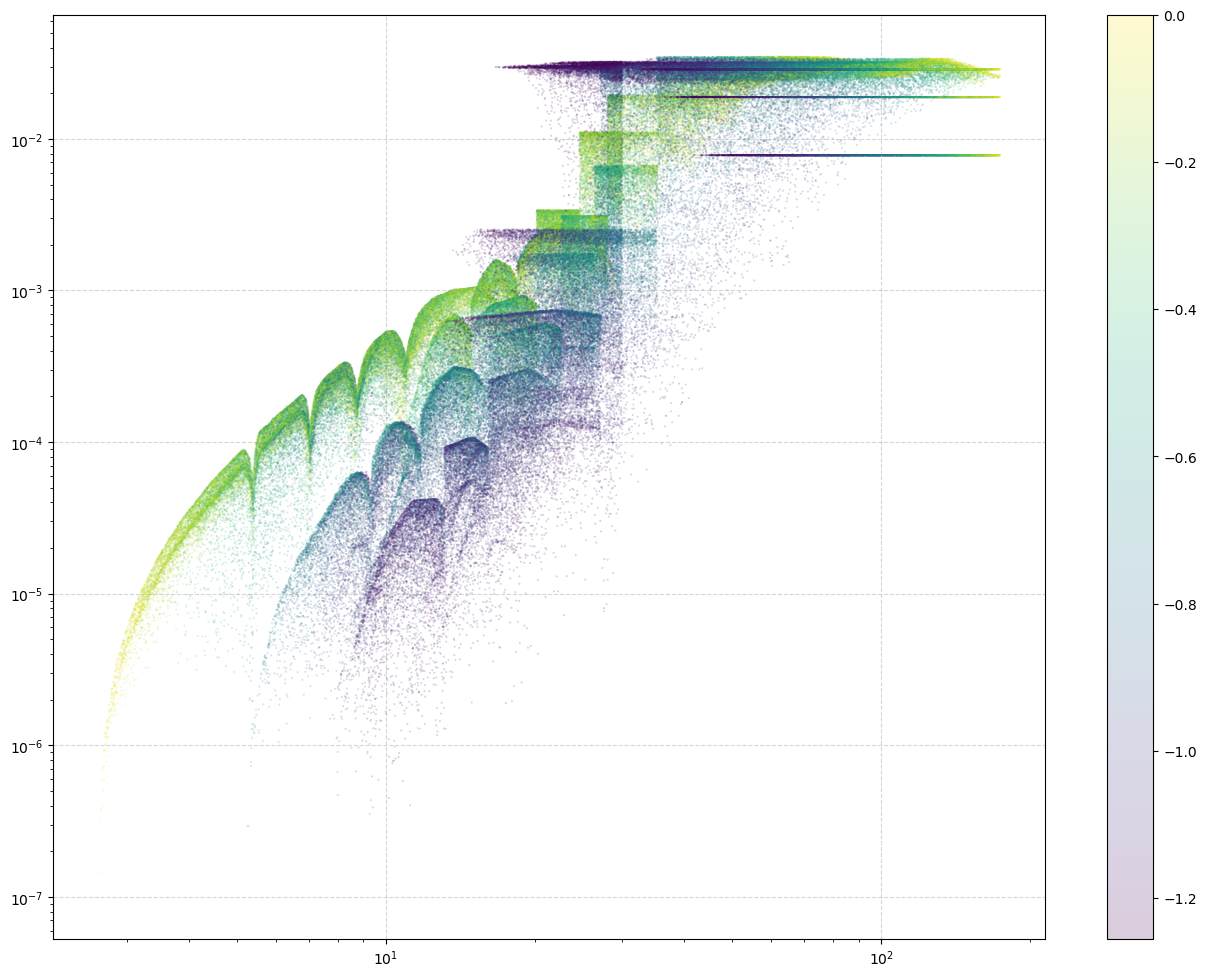

In [ ]:
plt.figure(figsize=(16,12));
PD = pickle.load( open(data_dir+'/Template_prior_HM_banks.pickle','rb'))
for ib in tqdm.tqdm(range(16)):
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),f'bank_{isb}','metadata.json'))
        p = PD['prior'][f'BBH_{ib}'][isb];
        interp_func, ndim = tg.get_prior_interp_func(f'BBH_{ib}', isb, 5,
            prior_data_file_path = data_dir+'/Template_prior_HM_banks.pickle')
        plt.scatter(bank.transform_pars(bank.pars)[:,0], interp_func(bank.coeffs[:,:ndim]), 
                    s=0.2, c=np.log10(bank.pars[:,1]/bank.pars[:,0]), vmin=np.log10(1/18), vmax=0, alpha=0.2)
                    # marker=markers[isb], alpha=0.2, label=f"({ib}, {isb})")
    # plt.scatter(bank.transform_pars(bank.pars)[:,0], interp_func(bank.coeffs[:,:ndim]), 
    #             s=0.2, c=bank.transform_pars(bank.pars)[:,2], vmin=-1, vmax=1)
        if isb==0 and ib==0:
            plt.colorbar()
plt.yscale('log')
plt.xscale('log')
# plt.legend()

100%|███████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.41s/it]


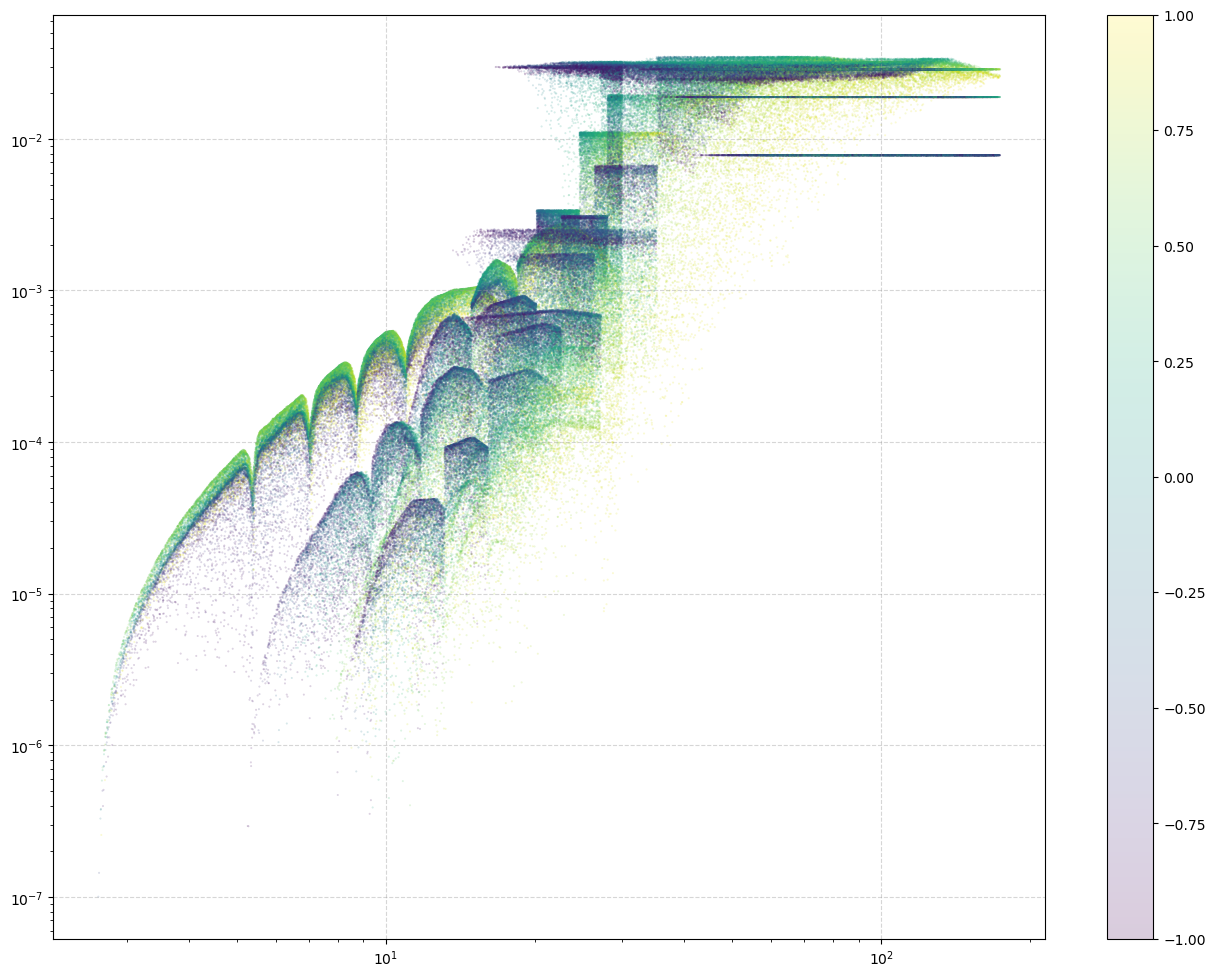

In [ ]:
plt.figure(figsize=(16,12));
PD = pickle.load( open(data_dir+'/Template_prior_HM_banks.pickle','rb'))
for ib in tqdm.tqdm(range(16)):
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),f'bank_{isb}','metadata.json'))
        p = PD['prior'][f'BBH_{ib}'][isb];
        interp_func, ndim = tg.get_prior_interp_func(f'BBH_{ib}', isb, 5,
            prior_data_file_path = data_dir+'/Template_prior_HM_banks.pickle')
        plt.scatter(bank.transform_pars(bank.pars)[:,0], interp_func(bank.coeffs[:,:ndim]), 
                    s=0.2, c=bank.transform_pars(bank.pars)[:,2], vmin=-1, vmax=1, alpha=0.2)
        if isb==0 and ib==0:
            plt.colorbar()
plt.yscale('log')
plt.xscale('log')

### 22-only code copied from Jonathan

In [ ]:
# This code was copy-pasted from Jonathan's notebook(s) and is not being currently used
# Talk to Jonathan for more details

In [ ]:
data_dir = '/data/jayw/IAS/GW/Data/HM/Template_prior/calpha_samples_1e7'

In [ ]:
import template_bank_generator as tg22
import template_bank_params_O3a as tbp22

In [ ]:
tg22.draw_samples_from_bank('BBH_4',1000,200, '/data/jayw/IAS/GW/Data/HM/calpha_samples/JM/Jay_files/',2)

/data/jayw/IAS/GW/gw_detection_ias/template_bank_generator.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pars[i, :] = np.array((m1, m2, s1z, s2z, l1, l2))


collected 1 in subbank 0
collected 0 in subbank 1
collected 0 in subbank 2
collected 0 in subbank 3
collected 0 in subbank 4
collected 35 in subbank 0
collected 41 in subbank 1
collected 49 in subbank 2
collected 45 in subbank 3
collected 31 in subbank 4
collected 59 in subbank 0
collected 96 in subbank 1
collected 98 in subbank 2
collected 83 in subbank 3
collected 65 in subbank 4
collected 84 in subbank 0
collected 140 in subbank 1
collected 158 in subbank 2
collected 129 in subbank 3
collected 90 in subbank 4
collected 121 in subbank 0
collected 187 in subbank 1
collected 199 in subbank 2
collected 181 in subbank 3
collected 113 in subbank 4
done collecting!
collected 158 in subbank 0
collected 225 in subbank 1
collected 256 in subbank 2
collected 219 in subbank 3
collected 142 in subbank 4


In [ ]:
calpha_samples = (np.load(
        f'/data/jayw/IAS/GW/Data/HM/calpha_samples/JM/Jay_files/BBH_4_{0}_calpha_samples.npy'))

In [ ]:
# calpha_samples = []
# for i in range(5):
#     calpha_samples.append(np.load(
#         f'/data/jayw/IAS/GW/Data/HM/calpha_samples/JM/calpha_samples_1e5/BBH_4_{i}_calpha_samples.npy'))
# calpha_samples = np.concatenate(calpha_samples)

calpha_samples = (np.load(
        f'/data/jayw/IAS/GW/Data/HM/calpha_samples/JM/calpha_samples_1e5/BBH_4_{0}_calpha_samples.npy'))

In [ ]:
param_samples = []
for i in range(5):
    param_samples.append(np.load(
        f'/data/jayw/IAS/GW/Data/HM/calpha_samples/JM/calpha_samples_1e5/BBH_4_{i}_calpha_samples.npy'))
param_samples = np.concatenate(param_samples)

In [ ]:
calpha_samples.shape

(10000, 5)

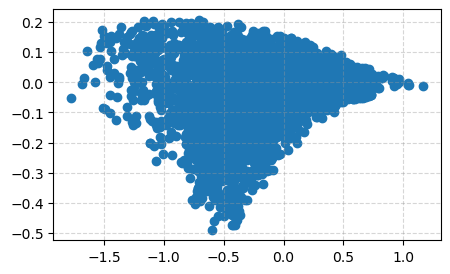

In [ ]:
plt.scatter(calpha_samples[:,0], calpha_samples[:,1])

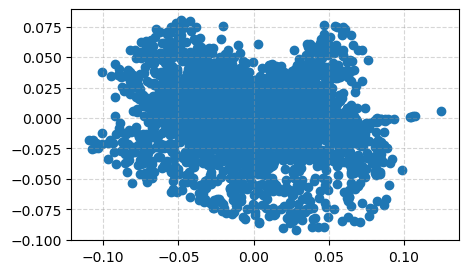

In [ ]:
plt.scatter(param_samples[:,2], param_samples[:,3])

In [ ]:
tg22.summarize_prior(data_dir,data_dir, name='PriorData_test_Jay', include_BBH_5=True)

BNS_0
BNS_1
BNS_2
NSBH_0
NSBH_1
NSBH_2
BBH_0
BBH_1
BBH_2
BBH_3
BBH_4
BBH_5


In [ ]:
ib=2; isb=0

In [ ]:
interp_func, ndim = tg22.get_prior_interp_func(f'BBH_{ib}', isb, 2,
        prior_data_file_path='/data/jayw/IAS/GW/Data/HM/Template_prior/JM_22_only/calpha_samples_1e5/Jay_pickle_data.pickle')
ndim

2

In [ ]:
interp_func_Seth, ndim = tg22.get_prior_interp_func(f'BBH_{ib}', isb, 2,
        prior_data_file_path='/scratch/lustre/tejaswi/GW/PriorData_light.pkl')
ndim

2

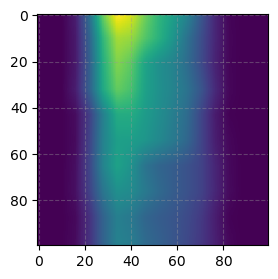

In [ ]:
arr_2d=[]
for i in np.linspace(-4,4,100):
    for j in np.linspace(-4,4,100):
        arr_2d.append([i,j])
plt.imshow(interp_func(arr_2d).reshape(100,100))

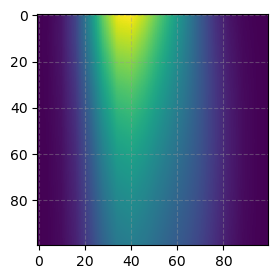

In [ ]:
plt.imshow(interp_func_Seth(arr_2d).reshape(100,100))

In [ ]:
bank22 = tg22.TemplateBank.from_json(os.path.join(tbp22.DIR,f'BBH_{ib}_multibank/bank_{isb}','metadata.json'))
bank_grid = bank22.get_coeff_grid(ndims=2, delta_calpha=0.3)[:,:ndim]
calpha_samples = np.load(f'/data/jayw/IAS/GW/Data/HM/Template_prior/JM_22_only/calpha_samples_1e5/BBH_{ib}_{isb}_calpha_samples.npy')

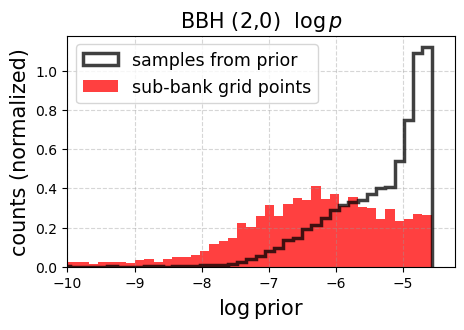

In [ ]:
_,bins,_ = plt.hist(np.log(interp_func_Seth(calpha_samples[:,:ndim])), bins=50, alpha=0.75,
         label='samples from prior', density=True, histtype='step',color='k', linewidth=2.5);
plt.hist(np.log(interp_func_Seth(bank_grid[:,:ndim])), bins=bins, alpha=0.75,
         label='sub-bank grid points', density=True, histtype='stepfilled', color='r');
plt.legend(fontsize=12.5, loc='upper left')
plt.ylabel('counts (normalized)', fontsize=15)
plt.xlabel(r'$\log {\rm prior}$', fontsize=15)
# axs[1,1].yaxis.set_label_position("right")
# axs[1,1].yaxis.tick_right()
plt.title(f'BBH ({ib},{isb})  $\log p$', fontsize=15)
plt.xlim(left=-10);

/data/jayw/IAS/GW/gw_detection_ias/template_bank_generator.py:2697: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_axes = np.array(grid_axes[:grid_dims])
/tmp/ipykernel_1375703/939373391.py:52: RuntimeWarning: divide by zero encountered in log
  im01 = axs[0,1].imshow(np.log(h).T, interpolation='None',


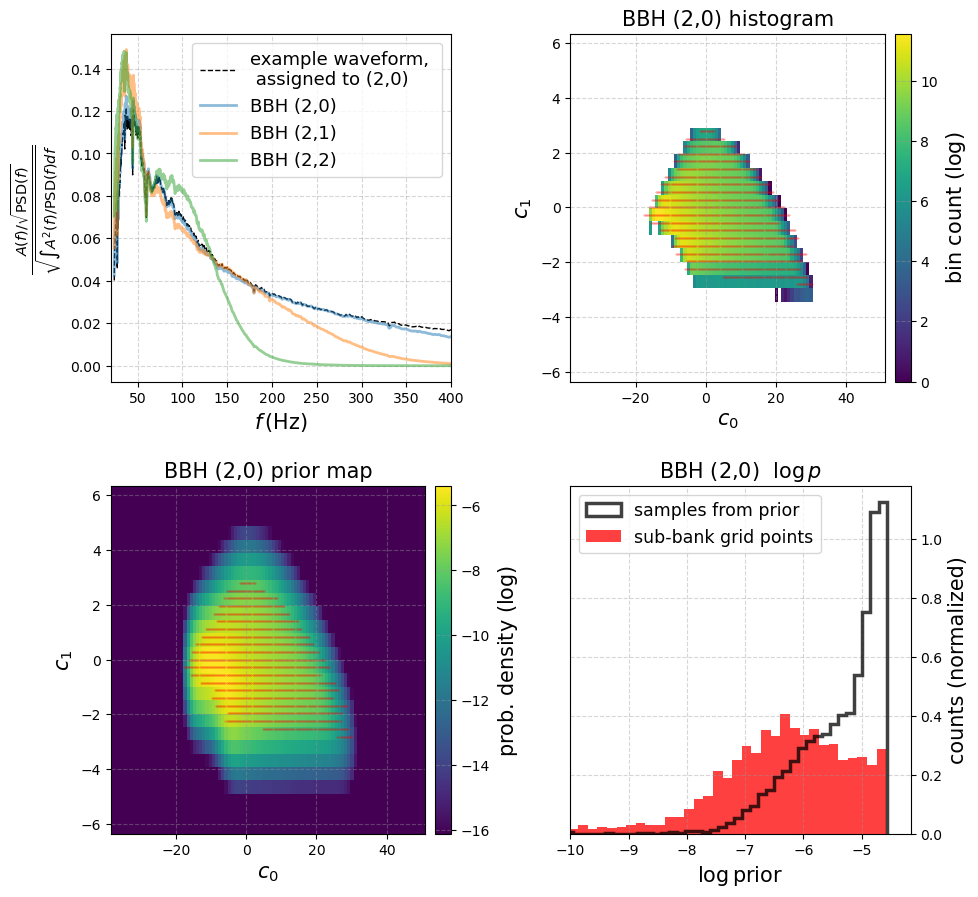

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
PD = pickle.load( open(f'/scratch/lustre/tejaswi/GW/PriorData_light.pkl','rb'))
test_sets_paths = {};
for mb_key in PD['N_samples'].keys():
    test_sets_paths[mb_key]=  [  os.path.join( f'/data/jayw/IAS/GW/Data/HM/Template_prior/JM_22_only/calpha_samples_1e5',
                                              f'{mb_key}_{x}_calpha_samples.npy') for x in 
                       range(len(PD['N_samples'][mb_key] ) ) ] 


ndim=2
fig, axs = plt.subplots( nrows=2, ncols=2 , figsize=(10,10))

mb_key = 'BBH_2';
sbi = 0
# show the sub-bank assignment thing for BBH 2 
mb=tbp22.load_multibanks([mb_key])[mb_key]

pars = np.load( f'/data/jayw/IAS/GW/Data/HM/Template_prior/JM_22_only/calpha_samples_1e5/{mb_key}_{sbi}_phys_param_samples.npy')[2,:]
par_dict = {'m1': pars[0], 'm2': pars[1], 's1z': pars[2], 's2z': pars[3]}
sb = mb.subbanks[0]
wf_fd = sb.gen_wf_fd_from_pars(fs_out=sb.fs_basis, **par_dict, approximant='IMRPhenomD') 
wf_amp_norm = np.abs(wf_fd)/sb.asdf(sb.fs_basis)/\
              np.trapz(  y= (np.abs(wf_fd)/sb.asdf(sb.fs_basis))**2, x=sb.fs_basis    )**(1/2)
sb = mb.subbanks[0]


axs[0,0].plot(sb.fs_basis, wf_amp_norm , label='example waveform, \n assigned to (2,0)',
              ls='--' ,c='k', linewidth=1, alpha=1)

for i,sb in enumerate(mb.subbanks):
    norm_amp = sb.amp/sb.asdf(sb.fs_basis) / np.trapz(y= (sb.amp/sb.asdf(sb.fs_basis))**2, x=sb.fs_basis)**(1/2)
    axs[0,0].plot(sb.fs_basis, norm_amp ,
                  label=f'{mb_key.replace("_"," (")},{i})', alpha=0.5,
                 linewidth=2)



axs[0,0].legend(fontsize=13)
axs[0,0].set_xlabel('$f\,($Hz$)$' , fontsize=15)
axs[0,0].set_ylabel(r'$\frac{A(f)/\sqrt{{\rm PSD}(f)}}{\sqrt{\int A^2(f)/{\rm PSD}(f) df }}$ ', fontsize=15)
axs[0,0].set_xlim(left=20, right=400);

# do 2d histogram
edges = PD['hist_axes_edges'][mb_key][sbi]
extent=[edges[0][0],edges[0][-1], edges[1][0],edges[1][-1]]
h = PD['hist'][mb_key][sbi];
p = PD['prior'][mb_key][sbi];

grid = mb.subbanks[sbi].get_coeff_grid(ndims=2, delta_calpha=0.3)[:,:ndim]


im01 = axs[0,1].imshow(np.log(h).T, interpolation='None',
                extent=extent, origin='lower', aspect='auto');
axs[0,1].scatter(grid[:,0],grid[:,1], marker='.',color='r', s=0.1)
axs[0,1].set_aspect('auto');
axs[0,1].set_xlabel(r'$c_0$', fontsize=15);
axs[0,1].set_ylabel(r'$c_1$', fontsize=15);
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar01 = fig.colorbar(im01, cax=cax)
cbar01.set_label(r'bin count $(\log)$', rotation=90, fontsize=15)
axs[0,1].set_title(r'BBH (2,0) histogram', fontsize=15)
# show the 2d prior map

im10 = axs[1,0].imshow(np.log(p).T, interpolation='None',
                extent=extent, origin='lower', aspect='auto');
axs[1,0].set_aspect('auto');
axs[1,0].set_xlabel(r'$c_0$', fontsize=15);
axs[1,0].set_ylabel(r'$c_1$', fontsize=15);
axs[1,0].scatter(grid[:,0],grid[:,1],marker='.',color='r', s=0.1)
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar10 = fig.colorbar(im10, cax=cax)
cbar10.set_label(r'prob. density $(\log)$', rotation=90, fontsize=15)

axs[1,0].set_title(r'BBH (2,0) prior map', fontsize=15)

# show the prior scores histograms
samples = np.load( test_sets_paths[mb_key][sbi]   )
pf,ndim = tg22.get_prior_interp_func(mb_key, sbi, prior_data=PD)
lp = np.log(pf(samples[:,:ndim]))

lp_grid = np.log(pf(grid))
axs[1,1].hist(lp, bins=50, alpha=0.75, label='samples from prior', density=True, histtype='step',color='k', linewidth=2.5);
axs[1,1].hist(lp_grid, bins=50, alpha=0.75, label='sub-bank grid points', density=True, histtype='stepfilled', color='r');
axs[1,1].legend(fontsize=12.5, loc='upper left')
axs[1,1].set_ylabel('counts (normalized)', fontsize=15)
axs[1,1].set_xlabel(r'$\log {\rm prior}$', fontsize=15)
axs[1,1].yaxis.set_label_position("right")
axs[1,1].yaxis.tick_right()
axs[1,1].set_title(r'BBH (2,0)  $\log p$', fontsize=15)
axs[1,1].set_xlim(left=-10)


fig.subplots_adjust(left=0.1,
                     bottom=0.1, 
                     right=0.9, 
                     top=0.9, 
                     wspace=0.35, 
                     hspace=0.3)
# fig.savefig(fname = \
#             os.path.join('/home/labs/barakz/Collaboration-gw/mushkin/Template_Prior/'
#                          ,'example_multibank_prior_hists_BBH_2.pdf'))